# Amazon reviews

> To get a better notebook formatting, [click here](https://nbviewer.jupyter.org/github/Coac/epfl-ada/blob/master/Project/Project.ipynb).

> Please also check the [readme](https://github.com/Coac/epfl-ada/blob/master/Project/README.md) containing additional explanations.

This notebook contains an exploratory analysis of one specific category of products of the Amazon reviews. Our objective is to be able to understand how reviews are distributed and find some useful insights to provide a deeper analysis to answer our research questions.

## Summary

1. [Data importation](#Data-importation)
2. [Descriptive analysis](#Descriptive-analysis)
3. [Correlations](#Correlations)
4. [Words occurences](#Words-occurences)
5. [Machine learning exploratory](#Machine-learning-exploratory)
6. [Next milestone](#Next-milestone)

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import warnings
from datetime import datetime
from matplotlib import pyplot as plt
import math as math

## Data importation

We first start by importing data. Because we focus on one specific category (*video games*), we won't need to use Spark here.

### Download the data

We will use the 5-core reviews which can be downloaded here: http://jmcauley.ucsd.edu/data/amazon/links.html. The exact file used for video games import is http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Video_Games_5.json.gz.

### File preparation

After downloading the file, we turn it to a valid, json array to ease importation. We use the following sed commands to do so:

```sh
sed -i '1s/^/[/' data/file.json # Starts JSON array
sed -i 's/$/,/' data/file.json # Separate objects with commas
sed -i '$ s/,$/]/g' data/file.json # Ends JSON array
```

### Pandas importation

#### Load products reviews


We import data and start by doing some simple cleaning. Dates are stored in two different formats (`reviewTime` and `unixReviewTime`). We will use the latest one to create a new `date` field with standard DateTime format, which will be easier to handle.

We create a two-level index to allow grouping reviews per product and reviewer.

In [2]:
video_games = pd.read_json('./data/video-games.json')

# Cleaning dates
del video_games['reviewTime'] # Duplicated information (already in unix review time)
video_games['date'] = pd.to_datetime(video_games['unixReviewTime'], unit='s')
del video_games['unixReviewTime']

video_games.set_index(['asin', 'reviewerID'], inplace=True)

assert video_games.index.is_unique, 'There should be no more than one review per person per product'

video_games.dtypes

helpful                 object
overall                  int64
reviewText              object
reviewerName            object
summary                 object
date            datetime64[ns]
dtype: object

We can see data types are already guessed by Pandas. We need, however, to reformat the `helpful` field. It is currently stored as an array of two values, the first one describing how many users voted the review was helpful and the second one describing how many votes the review received.

### Data formatting

To ease data handling, we will calculate the `helpfulRate` of each comment. It will help us extracting which reviewers are providing the best reviews on one or multiple products. When a review does not have any helpful votes, the rate will be set to `-1`.

We also store the number of total reviews in a new row so we can take rid of the helpful array.

In [3]:
def helpful_rate(row):
    '''
    Calculates the helpful rate of a review by determining what
    percentage of the votes described the review as "helpful".
    '''
    was_helpful = row.helpful[0]
    total_evaluations = row.helpful[1]
    
    if total_evaluations == 0:
        return -1
    
    return was_helpful/total_evaluations

def helpful_count(row):
    '''
    Gets the total number of helpful votes for a review
    '''
    return row.helpful[1]

video_games['helpfulRate'] = video_games.apply(helpful_rate, axis=1)
video_games['helpfulCount'] = video_games.apply(helpful_count, axis=1)
del video_games['helpful']

assert len(video_games[video_games['helpfulCount'] == 0]) == len(video_games[video_games['helpfulRate'] == -1])

video_games.head()

overall  \
asin       reviewerID                
0700099867 A2HD75EMZR8QLN        1   
           A3UR8NLLY1ZHCX        4   
           A1INA0F5CWW3J4        1   
           A1DLMTOTHQ4AST        3   
           A361M14PU2GUEG        4   

                                                                  reviewText  \
asin       reviewerID                                                          
0700099867 A2HD75EMZR8QLN  Installing the game was a struggle (because of...   
           A3UR8NLLY1ZHCX  If you like rally cars get this game you will ...   
           A1INA0F5CWW3J4  1st shipment received a book instead of the ga...   
           A1DLMTOTHQ4AST  I got this version instead of the PS3 version,...   
           A361M14PU2GUEG  I had Dirt 2 on Xbox 360 and it was an okay ga...   

                                                 reviewerName  \
asin       reviewerID                                           
0700099867 A2HD75EMZR8QLN                                 123   
           A3UR8NLLY1ZHCX  Alejandro Henao "Electronic Junky"   
           A1INA0F5CWW3J4          Amazon Shopper "Mr.Repsol"   
           A1DLMTOTHQ4AST                            ampgreen   
           A361M14PU2GUEG        Angry Ryan "Ryan A. Forrest"   

                                                                   summary  \
asin       reviewerID                                                        
0700099867 A2HD75EMZR8QLN         Pay to unlock content? I don't think so.   
           A3UR8NLLY1ZHCX                                  Good rally game   
           A1INA0F5CWW3J4                                        Wrong key   
           A1DLMTOTHQ4AST  awesome game, if it did not crash frequently !!   
           A361M14PU2GUEG                                           DIRT 3   

                                date  helpfulRate  helpfulCount  
asin       reviewerID                                            
0700099867 A2HD75EMZR8QLN 2012-07-09     0.666667            12  
           A3UR8NLLY1ZHCX 2013-06-30    -1.000000             0  
           A1INA0F5CWW3J4 2014-06-28    -1.000000             0  
           A1DLMTOTHQ4AST 2011-09-14     0.700000            10  
           A361M14PU2GUEG 2011-06-14     1.000000             2

Here is a first view of the data. All the reviews are grouped by product described by its product ID (`asin`). Then, for each product, all the reviews are indexed by the reviewer.

Each column of the dataframe is self-descriptive (notice that `overall` is the grade given from the reviewer in a scale between 1 and 5) and data types are allowing us to perform our analysis.

#### Load products reviews

We now load *video games* metadata. The exact file used here is: http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/meta_Video_Games.json.gz. We had some trouble importing the file, so we had to make some transformations in addition to the `sed` ones, because strings were surrounded by simple quotes instead of double quotes. Here is the Python script we used:

```python
import ast
import json

with open('./data/video-games.meta.json', 'r') as metadata:
    raw_data = metadata.read().replace('\n', '')
    parsed_data = ast.literal_eval(raw_data)

with open('./data/video-games.meta.parsed.json', 'w') as parsed:
    json.dump(parsed_data, parsed)
```

In [4]:
video_games_meta = pd.read_json('./data/video-games.meta.parsed.json')

del video_games_meta['imUrl']
del video_games_meta['related'] # For now we remove related (also bought, also viewed and buy after viewing) products
del video_games_meta['categories'] # We get rid of the sub categories for now

video_games_meta.price.fillna(-1, inplace=True)
video_games_meta.title.fillna('', inplace=True)
video_games_meta.brand.fillna('', inplace=True)
video_games_meta.description.fillna('', inplace=True)

# The following line can be understood as:
# video_games_meta.salesRank.fillna({}, inplace=True)
# It is done using this process because Pandas won't take into account the empty {} with fillna()
video_games_meta.loc[video_games_meta['salesRank'].isnull(), ['salesRank']] = video_games_meta.loc[video_games_meta['salesRank'].isnull(), 'salesRank'].apply(lambda x: {})

video_games_meta.set_index(['asin'], inplace=True)

video_games_meta.head()

,brand,description,price,salesRank,title
asin,,,,,
0078764343,,Brand new sealed!,37.98,{'Video Games': 28655},
043933702X,,In Stock NOW. Eligible for FREE Super Saving ...,23.50,{'Video Games': 44080},
0439339987,,Grandma Groupers kelp seeds are missing and wi...,8.95,{'Video Games': 49836},
0439342260,,This software is BRAND NEW. Packaging may diff...,-1.00,{'Video Games': 49156},
0439339960,,a scholastic clubs fairs cd rom game,-1.00,{'Video Games': 52262},


We need to get rid of the nested objects and arrays. We will take into account only the `salesRank` for video games section.

In [5]:
def sales_rank(row):
    '''
    Returns the video games sales rank from the sub object
    '''

    if not 'Video Games' in row.salesRank.keys():
        return -1
    
    return row.salesRank['Video Games']
    
video_games_meta['rank'] = video_games_meta.apply(sales_rank, axis=1)
del video_games_meta['salesRank']

video_games_meta.head()

,brand,description,price,title,rank
asin,,,,,
0078764343,,Brand new sealed!,37.98,,28655
043933702X,,In Stock NOW. Eligible for FREE Super Saving ...,23.50,,44080
0439339987,,Grandma Groupers kelp seeds are missing and wi...,8.95,,49836
0439342260,,This software is BRAND NEW. Packaging may diff...,-1.00,,49156
0439339960,,a scholastic clubs fairs cd rom game,-1.00,,52262


Things are now clean in off to merge the two dataframes. We will allow to have duplicate `brand`, `description`, `price`, `title` and `rank` for each review as it will help finding correlations.

In [6]:
# We concatenate our dataframes based on the product ID index
video_games_ids = video_games.index.get_level_values('asin')

video_games['rank'] = video_games_meta.loc[video_games_ids]['rank'].values
video_games['description'] = video_games_meta.loc[video_games_ids]['description'].values
video_games['price'] = video_games_meta.loc[video_games_ids]['price'].values
video_games['title'] = video_games_meta.loc[video_games_ids]['title'].values
video_games['brand'] = video_games_meta.loc[video_games_ids]['brand'].values

video_games.head()

overall  \
asin       reviewerID                
0700099867 A2HD75EMZR8QLN        1   
           A3UR8NLLY1ZHCX        4   
           A1INA0F5CWW3J4        1   
           A1DLMTOTHQ4AST        3   
           A361M14PU2GUEG        4   

                                                                  reviewText  \
asin       reviewerID                                                          
0700099867 A2HD75EMZR8QLN  Installing the game was a struggle (because of...   
           A3UR8NLLY1ZHCX  If you like rally cars get this game you will ...   
           A1INA0F5CWW3J4  1st shipment received a book instead of the ga...   
           A1DLMTOTHQ4AST  I got this version instead of the PS3 version,...   
           A361M14PU2GUEG  I had Dirt 2 on Xbox 360 and it was an okay ga...   

                                                 reviewerName  \
asin       reviewerID                                           
0700099867 A2HD75EMZR8QLN                                 123   
           A3UR8NLLY1ZHCX  Alejandro Henao "Electronic Junky"   
           A1INA0F5CWW3J4          Amazon Shopper "Mr.Repsol"   
           A1DLMTOTHQ4AST                            ampgreen   
           A361M14PU2GUEG        Angry Ryan "Ryan A. Forrest"   

                                                                   summary  \
asin       reviewerID                                                        
0700099867 A2HD75EMZR8QLN         Pay to unlock content? I don't think so.   
           A3UR8NLLY1ZHCX                                  Good rally game   
           A1INA0F5CWW3J4                                        Wrong key   
           A1DLMTOTHQ4AST  awesome game, if it did not crash frequently !!   
           A361M14PU2GUEG                                           DIRT 3   

                                date  helpfulRate  helpfulCount  rank  \
asin       reviewerID                                                   
0700099867 A2HD75EMZR8QLN 2012-07-09     0.666667            12  6629   
           A3UR8NLLY1ZHCX 2013-06-30    -1.000000             0  6629   
           A1INA0F5CWW3J4 2014-06-28    -1.000000             0  6629   
           A1DLMTOTHQ4AST 2011-09-14     0.700000            10  6629   
           A361M14PU2GUEG 2011-06-14     1.000000             2  6629   

                                                                 description  \
asin       reviewerID                                                          
0700099867 A2HD75EMZR8QLN  Dirt 3 is a popular rally racing game for Play...   
           A3UR8NLLY1ZHCX  Dirt 3 is a popular rally racing game for Play...   
           A1INA0F5CWW3J4  Dirt 3 is a popular rally racing game for Play...   
           A1DLMTOTHQ4AST  Dirt 3 is a popular rally racing game for Play...   
           A361M14PU2GUEG  Dirt 3 is a popular rally racing game for Play...   

                            price title brand  
asin       reviewerID                          
0700099867 A2HD75EMZR8QLN  246.63              
           A3UR8NLLY1ZHCX  246.63              
           A1INA0F5CWW3J4  246.63              
           A1DLMTOTHQ4AST  246.63              
           A361M14PU2GUEG  246.63

### Missing values
We check if our data frame contains missing data

In [7]:
null_data = video_games[video_games.isnull().any(axis=1)]
print("There are", len(null_data), "rows containing missing values")

print("Columns with missing datas:", list(video_games.columns[video_games.isnull().any()]))

null_data.head()

There are 2813 rows containing missing values
Columns with missing datas: ['reviewerName']


overall  \
asin       reviewerID                
9861019731 A26HSO6VAFB2V4        5   
B00000F1GM A2WTO0ST2SUUY9        5   
B00000I1BF A3OU09O34BC73         5   
           ANLC4FX4QK23V         5   
B00000IWYT A1OYBF92TASIWN        5   

                                                                  reviewText  \
asin       reviewerID                                                          
9861019731 A26HSO6VAFB2V4      It works perfectly! Nothing is wrong with it.   
B00000F1GM A2WTO0ST2SUUY9  For those of you who haven't played Super Mari...   
B00000I1BF A3OU09O34BC73   classic game for the ps1. i love it and it sti...   
           ANLC4FX4QK23V   I was feeling nostalgic so I bought this game ...   
B00000IWYT A1OYBF92TASIWN  Wow...the only Game Boy games that even come c...   

                          reviewerName                              summary  \
asin       reviewerID                                                         
9861019731 A26HSO6VAFB2V4          NaN                             Perfect!   
B00000F1GM A2WTO0ST2SUUY9          NaN                Super Mario 64 Review   
B00000I1BF A3OU09O34BC73           NaN                             so fun!!   
           ANLC4FX4QK23V           NaN                 Blast from the past!   
B00000IWYT A1OYBF92TASIWN          NaN  By far, the best Game Boy game ever   

                                date  helpfulRate  helpfulCount  rank  \
asin       reviewerID                                                   
9861019731 A26HSO6VAFB2V4 2014-07-13         -1.0             0   579   
B00000F1GM A2WTO0ST2SUUY9 2013-01-10          1.0             3   699   
B00000I1BF A3OU09O34BC73  2014-07-13         -1.0             0  2059   
           ANLC4FX4QK23V  2013-06-17         -1.0             0  2059   
B00000IWYT A1OYBF92TASIWN 2001-04-16         -1.0             0  4422   

                                                                 description  \
asin       reviewerID                                                          
9861019731 A26HSO6VAFB2V4  Compatible with:\nNINTENDO Wii & Gamecube\nPac...   
B00000F1GM A2WTO0ST2SUUY9  The game that launched the Nintendo 64 system ...   
B00000I1BF A3OU09O34BC73   Spyro is a cute purple dragon in a bit of a pi...   
           ANLC4FX4QK23V   Spyro is a cute purple dragon in a bit of a pi...   
B00000IWYT A1OYBF92TASIWN  The legendary Link of Hirule tackles a new que...   

                            price  \
asin       reviewerID               
9861019731 A26HSO6VAFB2V4    4.42   
B00000F1GM A2WTO0ST2SUUY9  299.99   
B00000I1BF A3OU09O34BC73    90.00   
           ANLC4FX4QK23V    90.00   
B00000IWYT A1OYBF92TASIWN  186.74   

                                                                       title  \
asin       reviewerID                                                          
9861019731 A26HSO6VAFB2V4  64MB 1019 Block Memory Card compatible for Wii...   
B00000F1GM A2WTO0ST2SUUY9                                                      
B00000I1BF A3OU09O34BC73                                                       
           ANLC4FX4QK23V                                                       
B00000IWYT A1OYBF92TASIWN                                                      

                             brand  
asin       reviewerID               
9861019731 A26HSO6VAFB2V4  Generic  
B00000F1GM A2WTO0ST2SUUY9           
B00000I1BF A3OU09O34BC73            
           ANLC4FX4QK23V            
B00000IWYT A1OYBF92TASIWN

Our dataframe contains missing values. However, it's only true for two columns : `reviewerName` and `reviewerNameLength`. These informations are not crucial for our analysis, so we can ignore this.

## Descriptive analysis

Our descriptive analysis will focus on several metrics taken from the above dataframe. We will first focus on the distribution of reviews grade (`overall`) and then analyse "helpful evaluations" of reviews. Finally, we will start searching for patterns in data distribution to prepare work for the next milestone.

### Distribution of possible review grades

We start by using a box plot to visualize how grades are distributed.

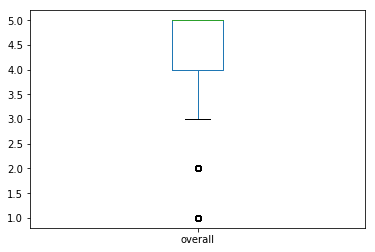

In [8]:
video_games.boxplot(column=['overall'], figsize=(8, 8), grid=False)

We can see that there is definitely more high grades (4, 5) than low ones. Let's describe data to get some insights.

In [9]:
video_games.overall.describe()

count    231780.000000
mean          4.086397
std           1.202330
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: overall, dtype: float64

We have 231780 reviews, with a mean of 4.08 and a standard deviation of 1.20.

When focusing at **robust statistics** only, we can see that the median is 5, and more than 75% of the reviews have awarded 4 or 5 grade to the product.

Let's see data distribution using a bar plot:

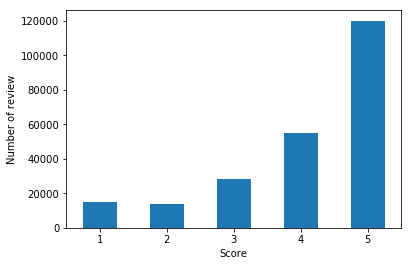

In [10]:
plt.xlabel('Score')
plt.ylabel('Number of review')
video_games.overall.value_counts(ascending=True).sort_index().plot(kind='bar', rot=0)

This confirms what was found before. We can do some assumptions about this distribution:

- The people may be more likely to thank the product quality by posting a review than to say their displeasure
- Amazon sell more good quality product (here video game) than bad one
- The 5 stars review can be due to the presence of fakes/paid review

We also can see that there are more reviews with `1` grade than `2`. This could be understood as people underrating products when they are not fully satisfied. It may also be used by customers to counterbalance a too high grade on a product, based on their opinions.

We now count the number of reviews per product to see if products are equally reviewed:

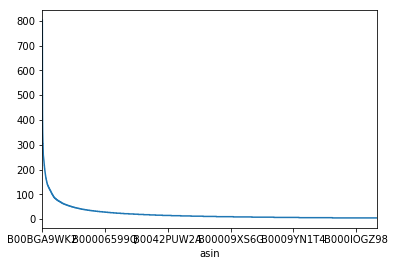

In [11]:
reviews_count_per_product = video_games.groupby(['asin']).overall.count().sort_values(ascending=False)

reviews_count_per_product.plot()

We seem to have a power law. However when using a logarithmic plot, we can see it is not:

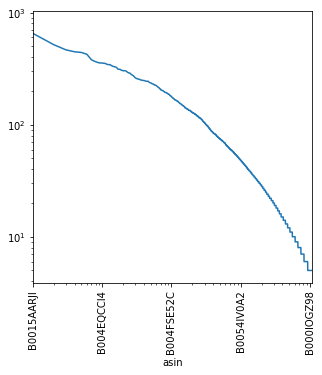

In [12]:
warnings.simplefilter('ignore') # Ignoring warning about non positive xlimit

reviews_count_per_product.plot(logy=True, logx=True, rot=90, figsize=(5, 5))

Let's see if users tend to review products when they are pricy:

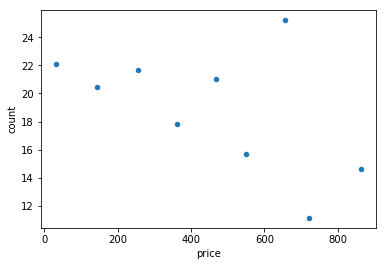

In [13]:
nb_reviews_per_product = pd.DataFrame()

# We count the number of reviews per product
nb_reviews_per_product['count'] = video_games[video_games.price > 0].groupby('asin').overall.count()
# We also add the product price
nb_reviews_per_product['price'] = video_games[video_games.price > 0].groupby('asin').price.mean()

# We create price beans because we have more products in specific price ranges
bins = range(0, 1000, 100)
nb_reviews_per_product['price_group'] = pd.cut(nb_reviews_per_product['price'], bins, labels=range(1, 10))#.plot(kind='scatter', x='price', y='count')

nb_reviews_per_product.groupby(['price_group']).mean().plot(kind='scatter', x='price', y='count')

We can't conclude much here. We can see a spike around 600$ which is due to existing game consoles at this price range, which are clearly more popular.

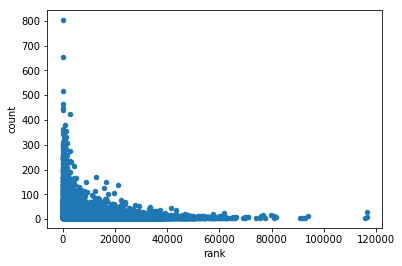

In [14]:
nb_reviews_per_product = pd.DataFrame()

nb_reviews_per_product['count'] = video_games.groupby('asin').overall.count()
nb_reviews_per_product['rank'] = video_games.groupby('asin').rank.mean()

nb_reviews_per_product.plot(kind='scatter', x='rank', y='count')

In [15]:
# We use spearman correlation here because we definitely
# can't have a linear relation between the two based on above graph
nb_reviews_per_product.corr(method='spearman') 

,count,rank
count,1.000000,-0.443484
rank,-0.443484,1.000000


Results seems logical, if a product is well-ranked, it is most likely because it has a lot of reviews, and has actually being purchased. The correlation is however weak as it only concerns the maximum number of reviews. We can still find high ranked products with few reviews.

Let's focus on the most reviewed product. The product is the "PlayStation 4 500GB Console". Notice that the price is not logical. After verification, there was no issue with the data importation. We will have to proceed with caution when using it as a feature.

In [16]:
most_reviewed = reviews_count_per_product.index[0]
most_reviewed_reviews = video_games.loc[most_reviewed]

most_reviewed_reviews.head()

,overall,reviewText,reviewerName,summary,date,helpfulRate,helpfulCount,rank,description,price,title,brand
reviewerID,,,,,,,,,,,,
A386ZNRX0TFFHX,4,I gave it 4 out of 5 stars because of lack of ...,NaN,"Great System, But...",2013-12-18,0.727273,11,13,,28.12,,
A2QYAFX7OCNRMO,3,PlayStation 4 is kind of hard to review right ...,NaN,Has potential...,2014-03-05,0.727273,11,13,,28.12,,
A3OQ3DU03L2GGO,5,Simply amazing. A huge step up from the PS3 an...,NaN,Stunning.,2013-12-01,0.727273,11,13,,28.12,,
A3H99DFEG68SR,3,So I've had the PS4 since launch and I have to...,1m2,I guess I expected more,2014-03-21,-1.000000,0,13,,28.12,,
A15LG7HS4WKKKS,5,Huge overall improvement over the PS3. The use...,"A. A. BADER ""Q8 AL BADER""","Best purchase all year.,",2014-03-06,0.700000,10,13,,28.12,,


We try to see if there are any trends in the reviews over time:

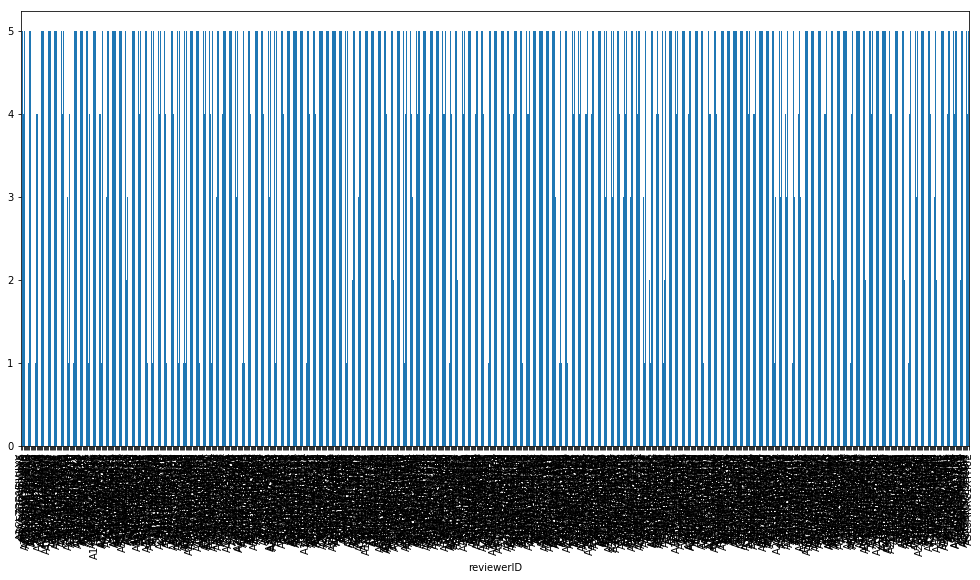

In [17]:
most_reviewed_reviews.sort_values(by=['date'], inplace=True)
most_reviewed_reviews.overall.plot(kind='bar', figsize=(17, 8), rot=90);

It is impossible to visually see any kind of trend. However, it may be possible using machine learning to determine if some grades can be deducted from the previous ones.

### Distribution of helpful rates

We do the same analysis for the helpful rate (after removing the reviews without evaluation):

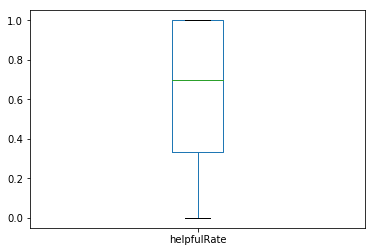

In [18]:
video_games[video_games.helpfulRate >= 0].boxplot(column=['helpfulRate'], figsize=(8, 8), grid=False);

Here, we can see rates are more widely distributed, let's do the same description as before.

In [19]:
video_games[video_games.helpfulRate >= 0].helpfulRate.describe()

count    139855.000000
mean          0.622347
std           0.369065
min           0.000000
25%           0.333333
50%           0.695652
75%           1.000000
max           1.000000
Name: helpfulRate, dtype: float64

Distribution seems more balanced, since first quartile is 0.33, median is 0.69 and last quartile is 0.75. We may however do the assumption that helpful reviews are more likely to be evaluated as even more helpful as Amazon will display those reviews first.

We now look at the distribution of helpful rates, considering all the sold products.

60.34% of reviews are evaluated


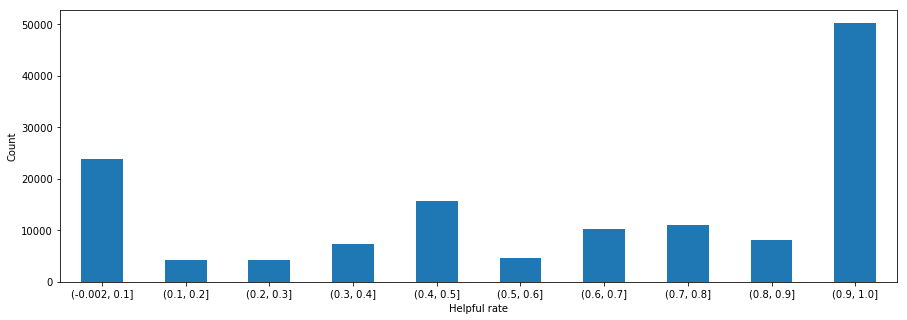

In [20]:
# We get all the "helpfulness rates" (removing the unrated comments)
helpfulRates = video_games[video_games.helpfulRate >= 0].helpfulRate

print(str(round(len(helpfulRates) * 100 / len(video_games.helpfulRate), 2)) + '% of reviews are evaluated')

plt.xlabel('Helpful rate')
plt.ylabel('Count')
helpfulRates.value_counts(ascending=True, bins=10).sort_index().plot(kind='bar', rot=0, figsize=(15, 5));

We can see two outsiders for reviews with less than 10% positive reviews and more than 90% positive reviews. This could be explained by the assumption made previously: the more a review is well rated, the more it is likely to get good rates. In the contrary, reviews with bad rates may be less visible on Amazon and may keep their low rates.

We will now sort the reviewers based on their helpful rate mean, to see if there are some top reviewers or very bad ones.

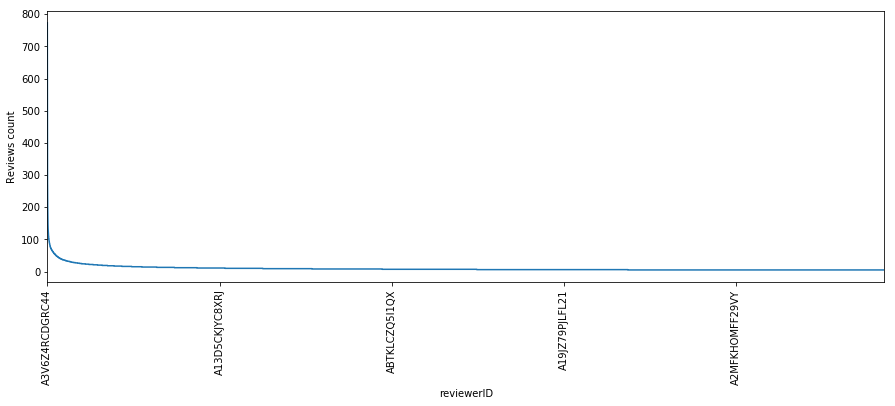

In [21]:
count_evaluations = video_games.groupby('reviewerID').overall.count().sort_values(ascending=False)

plt.ylabel('Reviews count')
count_evaluations.plot(rot=90, figsize=(15, 5));

In [22]:
count_evaluations.describe()

count    24303.000000
mean         9.537094
std         12.789697
min          5.000000
25%          5.000000
50%          7.000000
75%         10.000000
max        773.000000
Name: overall, dtype: float64

We try to zoom to get only evaluators with more than 30 evaluations. We can see that evaluations are done by a restricted number of evaluators providing the majority of evaluations.

1st best evaluator: 773
2nd best evaluator: 635
3rd best evaluator: 456
4th best evaluator: 450
5th best evaluator: 404
6th best evaluator: 320
7th best evaluator: 272
8th best evaluator: 268
9th best evaluator: 224
10th best evaluator: 220


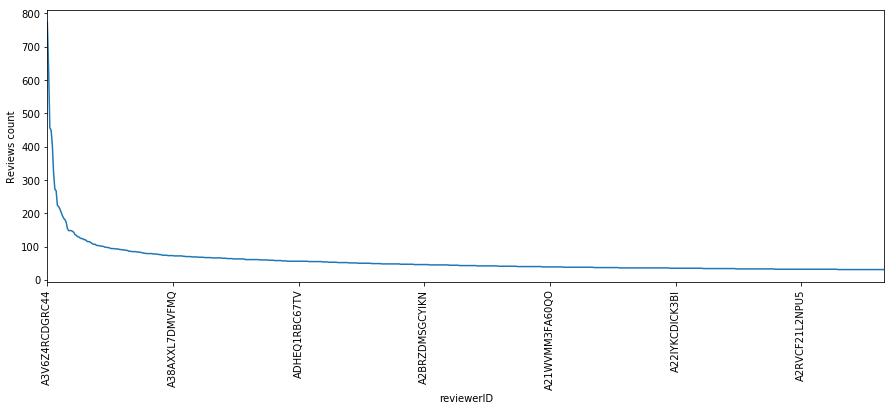

In [23]:
top_count_evaluations = count_evaluations[count_evaluations > 30]
plt.ylabel('Reviews count')
top_count_evaluations.plot(rot=90, figsize=(15, 5))

print('1st best evaluator: ' + str(top_count_evaluations[0]))
print('2nd best evaluator: ' + str(top_count_evaluations[1]))
print('3rd best evaluator: ' + str(top_count_evaluations[2]))
print('4th best evaluator: ' + str(top_count_evaluations[3]))
print('5th best evaluator: ' + str(top_count_evaluations[4]))
print('6th best evaluator: ' + str(top_count_evaluations[5]))
print('7th best evaluator: ' + str(top_count_evaluations[6]))
print('8th best evaluator: ' + str(top_count_evaluations[7]))
print('9th best evaluator: ' + str(top_count_evaluations[8]))
print('10th best evaluator: ' + str(top_count_evaluations[9]))

We seem to have a power law here. We try to confirm this using a logarithmic plot:

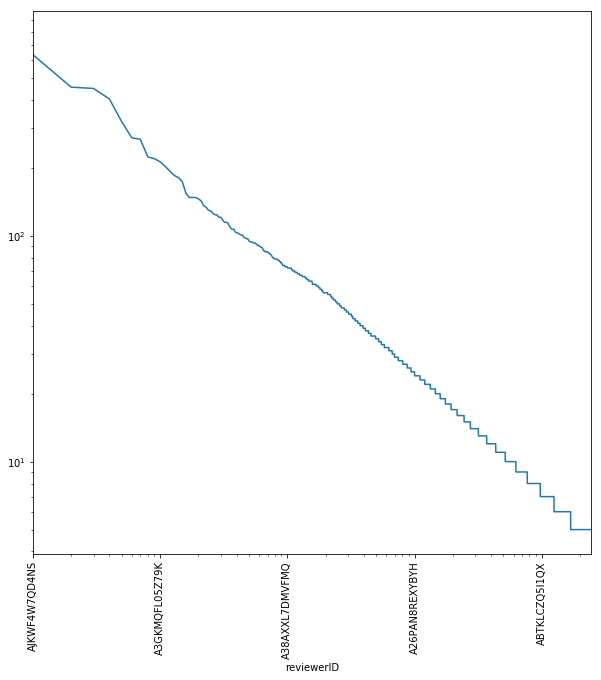

In [24]:
warnings.simplefilter('ignore') # Ignoring warning about non positive xlimit

count_evaluations.plot(logy=True, logx=True, rot=90, figsize=(10, 10));

We indeed have a power law.

### Analysis of the more productive reviewer

Focusing on the best evaluator, let's see if he provides well rated evaluations:

In [25]:
best_reviewer_id = top_count_evaluations.index[0]

print('Number of reviews: ' + str(video_games.groupby('reviewerID').get_group(best_reviewer_id).overall.count()))
video_games.groupby('reviewerID').get_group(best_reviewer_id).median()

Number of reviews: 773


overall            5.000000
helpfulRate        0.888889
helpfulCount       9.000000
rank            8736.000000
price             29.990000
dtype: float64

Comparing it with the other reviewers:

In [26]:
video_games.overall.median()

5.0

In [27]:
video_games[video_games.helpfulRate >= 0].helpfulRate.median()

0.6956521739130435

The best evaluator seems to be a normal person, his `helpfulRate` is above to the median (allowing to believe he does not flooded the products with fake reviews). He also gave more than 50% of 5 star grades. We don't get a lot of information here.

## Correlations

We add columns `reviewLength`, `summaryLength` and `reviewerNameLength` to the dataframe to take into account more metrics.

In [28]:
video_games['reviewLength'] = video_games['reviewText'].str.len()
video_games['summaryLength'] = video_games['summary'].str.len()
video_games['reviewerNameLength'] = video_games['reviewerName'].str.len()

video_games.head()

overall  \
asin       reviewerID                
0700099867 A2HD75EMZR8QLN        1   
           A3UR8NLLY1ZHCX        4   
           A1INA0F5CWW3J4        1   
           A1DLMTOTHQ4AST        3   
           A361M14PU2GUEG        4   

                                                                  reviewText  \
asin       reviewerID                                                          
0700099867 A2HD75EMZR8QLN  Installing the game was a struggle (because of...   
           A3UR8NLLY1ZHCX  If you like rally cars get this game you will ...   
           A1INA0F5CWW3J4  1st shipment received a book instead of the ga...   
           A1DLMTOTHQ4AST  I got this version instead of the PS3 version,...   
           A361M14PU2GUEG  I had Dirt 2 on Xbox 360 and it was an okay ga...   

                                                 reviewerName  \
asin       reviewerID                                           
0700099867 A2HD75EMZR8QLN                                 123   
           A3UR8NLLY1ZHCX  Alejandro Henao "Electronic Junky"   
           A1INA0F5CWW3J4          Amazon Shopper "Mr.Repsol"   
           A1DLMTOTHQ4AST                            ampgreen   
           A361M14PU2GUEG        Angry Ryan "Ryan A. Forrest"   

                                                                   summary  \
asin       reviewerID                                                        
0700099867 A2HD75EMZR8QLN         Pay to unlock content? I don't think so.   
           A3UR8NLLY1ZHCX                                  Good rally game   
           A1INA0F5CWW3J4                                        Wrong key   
           A1DLMTOTHQ4AST  awesome game, if it did not crash frequently !!   
           A361M14PU2GUEG                                           DIRT 3   

                                date  helpfulRate  helpfulCount  rank  \
asin       reviewerID                                                   
0700099867 A2HD75EMZR8QLN 2012-07-09     0.666667            12  6629   
           A3UR8NLLY1ZHCX 2013-06-30    -1.000000             0  6629   
           A1INA0F5CWW3J4 2014-06-28    -1.000000             0  6629   
           A1DLMTOTHQ4AST 2011-09-14     0.700000            10  6629   
           A361M14PU2GUEG 2011-06-14     1.000000             2  6629   

                                                                 description  \
asin       reviewerID                                                          
0700099867 A2HD75EMZR8QLN  Dirt 3 is a popular rally racing game for Play...   
           A3UR8NLLY1ZHCX  Dirt 3 is a popular rally racing game for Play...   
           A1INA0F5CWW3J4  Dirt 3 is a popular rally racing game for Play...   
           A1DLMTOTHQ4AST  Dirt 3 is a popular rally racing game for Play...   
           A361M14PU2GUEG  Dirt 3 is a popular rally racing game for Play...   

                            price title brand  reviewLength  summaryLength  \
asin       reviewerID                                                        
0700099867 A2HD75EMZR8QLN  246.63                       779             40   
           A3UR8NLLY1ZHCX  246.63                       304             15   
           A1INA0F5CWW3J4  246.63                       282              9   
           A1DLMTOTHQ4AST  246.63                      3489             47   
           A361M14PU2GUEG  246.63                       294              6   

                           reviewerNameLength  
asin       reviewerID                          
0700099867 A2HD75EMZR8QLN                 3.0  
           A3UR8NLLY1ZHCX                34.0  
           A1INA0F5CWW3J4                26.0  
           A1DLMTOTHQ4AST                 8.0  
           A361M14PU2GUEG                28.0

Before displaying the correlations, let's study how review's length are distributed (we only take into account reviews with at least one word).

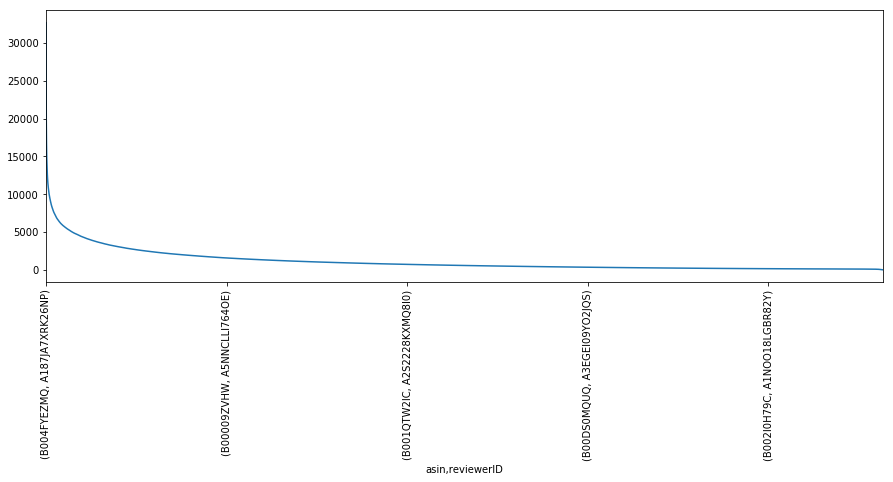

In [29]:
reviews_length = video_games[video_games.reviewLength > 0].reviewLength.sort_values(ascending=False)
reviews_length.plot(rot=90, figsize=(15, 5))

In [30]:
reviews_length.describe()

count    231736.000000
mean       1134.123628
std        1567.258380
min           3.000000
25%         235.000000
50%         576.000000
75%        1373.000000
max       32689.000000
Name: reviewLength, dtype: float64

As we can see, 50% of reviews have less than 576 words and 75% have less than 1373 words.

We display the correlation matrix and scatter plot:

In [31]:
video_games.corr()

,overall,helpfulRate,helpfulCount,rank,price,reviewLength,summaryLength,reviewerNameLength
overall,1.000000,-0.133272,-0.086515,-0.103580,0.054490,-0.062702,-0.074934,-0.009812
helpfulRate,-0.133272,1.000000,0.121019,0.111745,0.024150,0.294168,0.176459,0.099486
helpfulCount,-0.086515,0.121019,1.000000,-0.004194,0.007926,0.132578,0.056005,0.024202
rank,-0.103580,0.111745,-0.004194,1.000000,-0.044552,0.025594,0.024808,0.068894
price,0.054490,0.024150,0.007926,-0.044552,1.000000,0.018523,0.021714,0.011590
reviewLength,-0.062702,0.294168,0.132578,0.025594,0.018523,1.000000,0.309684,0.098276
summaryLength,-0.074934,0.176459,0.056005,0.024808,0.021714,0.309684,1.000000,0.094540
reviewerNameLength,-0.009812,0.099486,0.024202,0.068894,0.011590,0.098276,0.094540,1.000000


We plot the scatter matrix for each columns to avoid to fall in some bias (e.g. Simpson's paradox) by just looking at the correlation table.

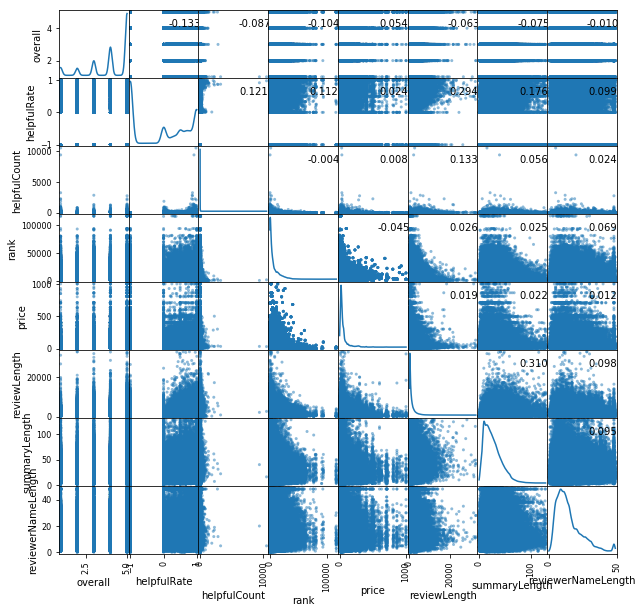

In [32]:
from pandas.tools.plotting import scatter_matrix

axes = scatter_matrix(video_games, alpha=0.5, diagonal='kde', figsize=(10, 10))
corr = video_games.corr().as_matrix()
for i, j in zip(*plt.np.triu_indices_from(axes, k=1)):
    axes[i, j].annotate("%.3f" %corr[i,j], (0.8, 0.8), xycoords='axes fraction', ha='center', va='center')

plt.show()

- There is some correlation between between `reviewLength` and the `helpfulRate`. We can think that more the `reviewLength` is high, more the review can contain more descriptions and arguments, so it can increase the helpfullness.   
- Then, the `summaryLength` and the `reviewLength` seems to be also correlated. The more the review text is lengthy, the more the summary needs letters to summarize it.

## Serialize video_games using pickle

In [33]:
import pickle

with open('pickle/video_games.pkl', 'wb') as output:
    pickle.dump(video_games, output, pickle.HIGHEST_PROTOCOL)

## Words occurences

To do our `reviewText` words occurences, we will use the product which has the most reviews "PlayStation 4 500GB Console"

### Unigram

We print the top 10 words for each review grouped by the overall score.

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

def get_top_words(text_series, ngram):
    word_vectorizer = CountVectorizer(ngram_range=(ngram, ngram), analyzer='word', stop_words='english')
    sparse_matrix = word_vectorizer.fit_transform(text_series)
    frequencies = sum(sparse_matrix).toarray()[0]
    bigrams_freq = pd.DataFrame(frequencies, index=word_vectorizer.get_feature_names(), columns=['frequency']).sort_values(by=['frequency'], ascending=False)

    bigrams_freq = bigrams_freq.iloc[0:10]

    return bigrams_freq.index


top_words_per_overall = pd.DataFrame()

for i in range(5):
    top_words_per_overall["Score " + str(i+1)] = get_top_words(most_reviewed_reviews[most_reviewed_reviews.overall == (i+1)].reviewText, 1)
top_words_per_overall

,Score 1,Score 2,Score 3,Score 4,Score 5
0,ps4,ps4,ps4,ps4,ps4
1,sony,games,games,games,games
2,console,ps3,ps3,like,console
3,just,sony,sony,controller,controller
4,xbox,console,like,game,ps3
5,amazon,just,just,ps3,game
6,games,play,console,just,like
7,34,like,game,console,xbox
8,work,does,play,sony,great
9,like,really,controller,better,just


The words are kind of neutral, there is not real positive or negative sentiment word. Except for "great" for Score 5 but only at 9th position. We were waiting for the postive word to be more in Score 5 and negative Score 1. The top word for each overall score is "ps4" which is the product name.

But only one word can miss some context, it's a better idea to search for multiple words.

### Bigram

So we now display the top bigram

In [35]:
top_words_per_overall = pd.DataFrame()
for i in range(5):
    top_words_per_overall["Score " + str(i+1)] = get_top_words(most_reviewed_reviews[most_reviewed_reviews.overall == (i+1)].reviewText, 2)
top_words_per_overall

,Score 1,Score 2,Score 3,Score 4,Score 5
0,blue light,blu ray,touch pad,hard drive,xbox 360
1,safe mode,ps3 ps4,hard drive,play games,free games
2,hard drive,steam pc,ps4 does,free games,user interface
3,doesn work,firmware update,ps3 ps4,new controller,hard drive
4,light death,looking forward,like ps3,blu ray,remote play
5,customer service,incremental services,blu ray,xbox 360,games like
6,blinking blue,pc games,better ps3,games like,games look
7,59 99,ps2 ps3,sony support,remote play,ps plus
8,xbox ps4,ability play,looks like,blue light,play games
9,launch day,usb port,feel like,just like,blu ray


Unfortunately, two words does not capture the sentiment of the review. The most of the outputed bigram are just common nouns. We can't say by having just "xbox 360" or "blue light" determine if the score will be 5 or 1.

## Machine learning exploratory

We now use some machine learning methods to improve our analysis.

### TF-IDF 
We transform the review text to TF-IDF features to to the clustering

In [36]:
vectorizer = TfidfVectorizer(stop_words = 'english', min_df=5)
tfidf_matrix = vectorizer.fit_transform(most_reviewed_reviews.reviewText)

#### Clustering attempt

We try to determine if the occurences of certain word are specific to the a certain score. We try to cluster, using unsupervised learning, the reviews based on the tf-idf features to 5 groups. We hope we will find on each group the same overall score : 1 group for review score 1, another for score 2 etc...

##### KMeans

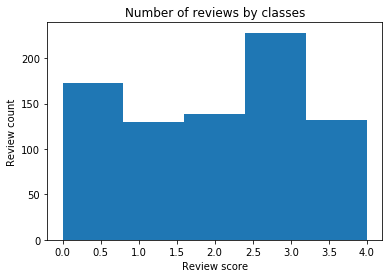

In [37]:
from sklearn.cluster import KMeans

k = 5
km = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=5)
km.fit(tfidf_matrix)

plt.hist(km.labels_, bins=k)
plt.xlabel('Review score')
plt.ylabel('Review count')

plt.title('Number of reviews by classes')
plt.show()

In [38]:
clusters = {}

for i in set(km.labels_):
    cluster = [most_reviewed_reviews.iloc[x] for x in np.where(km.labels_ == i)[0]]
    clusters[i] = pd.DataFrame(cluster)

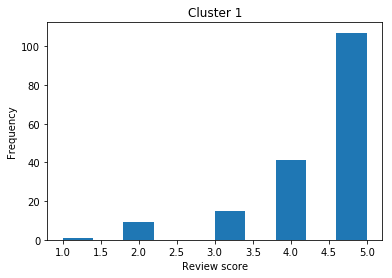

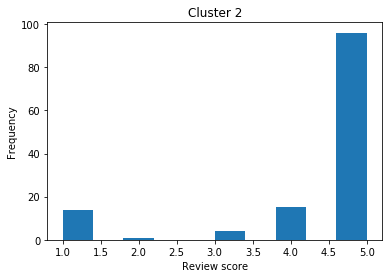

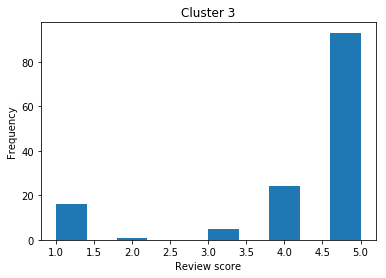

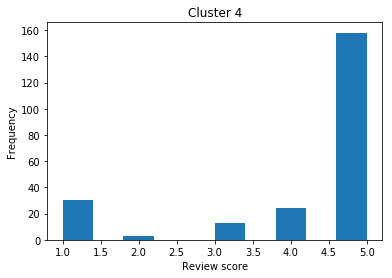

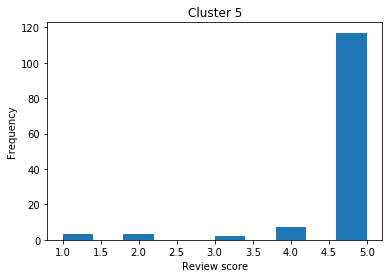

In [39]:
plt.title("Cluster 1")
plt.xlabel('Review score')
clusters[0].overall.plot(kind="hist");
plt.show()

plt.title("Cluster 2")
plt.xlabel('Review score')
clusters[1].overall.plot(kind="hist");
plt.show()

plt.title("Cluster 3")
plt.xlabel('Review score')
clusters[2].overall.plot(kind="hist");
plt.show()

plt.title("Cluster 4")
plt.xlabel('Review score')
clusters[3].overall.plot(kind="hist");
plt.show()

plt.title("Cluster 5")
plt.xlabel('Review score')
clusters[4].overall.plot(kind="hist");
plt.show()

It's not a great success. We dont have in each cluster only review with same score, but a mix. TF-IDF is unstable for such short document lengths.

For milestone 3, we will use the StarSpace embeddings instead of TF-IDF.

## Next milestone

### Regression model

#### Linear regression

We will now try to do some `helpfulRate` prediction using simple linear regression. We start by producting a scatter plot based on the insights we found previously. More precisely, we will here visualize the `helpfulRate` compared to the `reviewLength` to see if we can visually anticipate a linear correlation between the two:

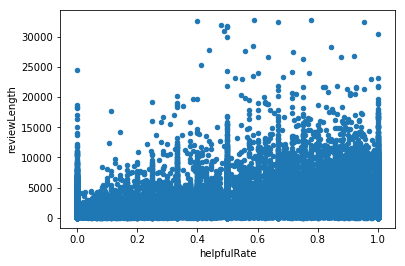

In [40]:
video_games[video_games.helpfulRate >= 0].plot(kind='scatter', x='helpfulRate', y='reviewLength')

We can see that it does not seem to have an explicit linear correlation here. We can still do the linear regression, as it is simple to implement. We, however, expect poor result here.

In [41]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score

lreg = linear_model.LinearRegression()

X = video_games[video_games.helpfulRate >= 0].loc[:,['reviewLength', 'summaryLength', 'rank', 'overall']]
x_train, x_cv, y_train, y_cv = train_test_split(X,video_games[video_games.helpfulRate >= 0].helpfulRate)

lreg.fit(x_train,y_train)
pred = lreg.predict(x_cv)

explained_variance_score(y_cv, pred)

0.12411981897969659

After several testings on multiple features, we found the best features combination to get a `variance score` of about 0.12. This is a really poor result considering the best possible score is 1.0.

### Classification

The task to predict directly a continuous value for the `helpfulRate` seems to be to complicated. We switched to a classification task, predicting if the review is helpful or not helpful.

Let's plot the distribution of the helpfulness.

In [63]:
# We only analyse reviews with an helpful rate...
helpful_video_games = video_games[video_games.helpfulRate >= 0]

# We also take only reviews with a minimum of three evaluations, to avoid bias
helpful_video_games = helpful_video_games[video_games.helpfulCount > 3]

# We clusterize our data into two categories: helpful and non-helpful reviews
helpful_video_games['wasHelpful'] = helpful_video_games['helpfulRate'].apply(lambda x: 'helpful' if x > 0.5 else 'notHelpful')

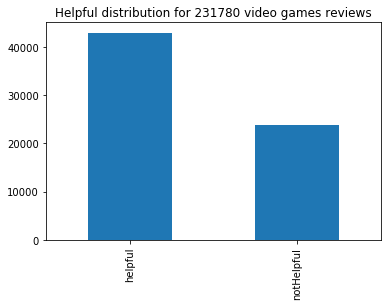

In [64]:
groupby_helpful = helpful_video_games.groupby('wasHelpful')

groupby_helpful['overall'].count().plot.bar(title='Helpful distribution for ' + str(len(video_games)) + ' video games reviews');
ax1 = plt.axes()
ax1.xaxis.label.set_visible(False)
plt.show()

We can see that there are a lot more helpful review than not helpful. We are faced to an imbalanced dataset. So we will use the `f1-score` metrics to evaluate our future models.

There are many features that we can take into account for our classification task, including for example using the review text itself. However, we will first use a simple neural networks model and basic features to see the behaviour.

#### First draft with neural networks

Considering the data distribution, usage of linear regression seems to be innapropriate. We chose to change completely our strategy by using neural networks. As we have important data aggregates, we may succeed in training a neural network to predict helpfulness.

##### Using only overall
We start by a naive approach, by trying to predict if a review was helpful only using the `overall` feature; meaning answering the question: "How well can we predict if a review is helpful based on the review grade?"

In [141]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score

label_encoder = LabelEncoder()
label_encoder.fit_transform(helpful_video_games['wasHelpful'])
    
def train_network(dataset, features, max_iter):
    y = dataset['wasHelpful']
    y = label_encoder.fit_transform(y)
    
    x = dataset.loc[:, features]

    x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.25)

    clf = MLPClassifier(hidden_layer_sizes=(100,100,100), max_iter=max_iter, alpha=0.0001,
                     solver='sgd', verbose=False,  random_state=21, tol=0.000000001)

    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)

    print("f1-score:", f1_score(y_test, y_pred, average='micro'))
    
    return clf, x, y

In [142]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
    
clf, x, y = train_network(helpful_video_games, ['overall'], 20)

f1-score: 0.691505930274


The f1-score is around 0.70 by only taking into account the initial rate, which is clearly better than a simple linear regression. Let's find out how our classifier works...

In [143]:
for i in range(1, 6):
    print(str(i) + ' star review: ' + str(label_encoder.inverse_transform(clf.predict(i))))

1 star review: ['notHelpful']
2 star review: ['notHelpful']
3 star review: ['helpful']
4 star review: ['helpful']
5 star review: ['helpful']


We get here a new insight about data distribution. One star reviews seems to have a lower helpful rate than other reviews. This may be due to overstated reviews and product bashing. Let's do a short descriptive analysis to confirm this new information.

Because we know we have high differences in the number of evaluations in each grade category, we use the standard error instead of the standard deviation to draw the error bars. This allows to mitigate the observations.

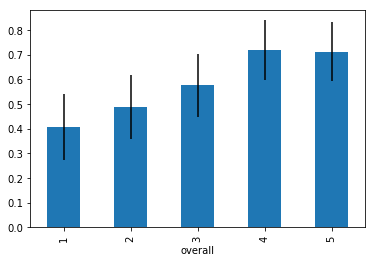

In [144]:
grouped_helpful_reviews = helpful_video_games.groupby(['overall']).helpfulRate
grouped_helpful_reviews.mean().plot(kind='bar', yerr=grouped_helpful_reviews.std()/math.sqrt(len(grouped_helpful_reviews)));

We can see that errors are important, due to the high variance of the results. This may be explained by the fact that using the overall only to find the final rank is not as good as taking multiple features into account.

After seing this plot and data distribution, we can understand why only 1 star reviews are getting are immediately considered as not helpful. We now cross validate to ensure results were representative of the reality.

In [160]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf, x, y, cv=3, scoring='f1_micro')
print("crossval f1-score:", np.mean(scores))

crossval f1-score: 0.54489771474


After cross-validation, we get more or less the f1-score of 0.70.

However, predicting the helpfulness of a review by sorting it as `true` or `false` based on the grade is not very helpful and creates an unwanted segregation in data. Considering Amazon would use these results to promote specific reviews, it may create an incentive for posting fake 5 star reviews to be put forward.

###### Predicting 3 class

Before testing against more features, we will create three clusters to determine if a review was helpful:

- 0 will mean the review is not helpful at all (less than 33% of the evaluations said it was useful)
- 1 will mean the review may be polemical (less than 66% of the evaluations said it was useful)
- 2 will mean the review was useful (more than 66% of the evaluations said it was useful)

In [154]:
helpful_video_games2 = helpful_video_games.copy()
helpful_video_games2['wasHelpful'] = helpful_video_games.helpfulRate.map(lambda x: 'notHelpful' if x < 0.33 else 'controversial' if x < 0.66 else 'helpful')

label_encoder2 = LabelEncoder()
label_encoder2.fit_transform(helpful_video_games2['wasHelpful'])

clf, x, y = train_network(helpful_video_games2, ['overall'], 100)

f1-score: 0.576554450701


The f1-score of our network dropped significantly. Let's find out how he classified our data:

In [157]:
for i in range(1, 6):
    print(str(i) + ' star review: ' + str(label_encoder2.inverse_transform(clf.predict(i))))

1 star review: ['notHelpful']
2 star review: ['helpful']
3 star review: ['helpful']
4 star review: ['helpful']
5 star review: ['helpful']


We can see that our neural networks is limited here, and have some difficulties determining when the reviews should be "polemical".
##### Using only reviewLength
We will now introduce more features to see if we can improve our f1-score score which dropped a lot.

In [161]:
# We increase the number of iterations as we have a higher scope of possibilities
clf, x, y = train_network(helpful_video_games2, ['reviewLength'], 1000)
scores = cross_val_score(clf, x, y, cv=3, scoring='f1_micro')
print("crossval f1-score:", np.mean(scores))

f1-score: 0.547322391278
crossval f1-score: 0.54489771474


In [159]:
for i in range(0, 100000):
    if clf.predict(i)[0] != label_encoder2.transform(['helpful'])[0]:
        print(i)

We can see with the previous code that our classifer always return *helpful* as the level of helpfulness of the review; it does not find any trend in the dataset.

##### Using only summaryLength

By using only the review length, we get a really lower range. It is not possible, only considering the review length, to determine if it would be helpful. We will need to go deeper and analyse the review contents.

In [162]:
clf, x, y = train_network(helpful_video_games2, ['summaryLength'], 1000)
scores = cross_val_score(clf, x, y, cv=3, scoring='f1_micro')
print("crossval f1-score:", np.mean(scores))

last_i = 0
for i in range(0, 32689):
    prediction = clf.predict(i)
    if prediction[0] != label_encoder2.transform(['notHelpful'])[0]:
        print(str(i) + ' characters: ' + str(label_encoder2.inverse_transform(prediction[0])))
        last_i = i

print(str(last_i+1) + ' characters: notHelpful')

f1-score: 0.545046124356
crossval f1-score: 0.54489771474
0 characters: helpful
1 characters: helpful
2 characters: helpful
3 characters: helpful
4 characters: helpful
5 characters: helpful
6 characters: helpful
7 characters: helpful
8 characters: helpful
9 characters: helpful
10 characters: helpful
11 characters: helpful
12 characters: helpful
13 characters: helpful
14 characters: helpful
15 characters: helpful
16 characters: helpful
17 characters: helpful
18 characters: helpful
19 characters: helpful
20 characters: helpful
21 characters: helpful
22 characters: helpful
23 characters: helpful
24 characters: helpful
25 characters: helpful
26 characters: helpful
27 characters: helpful
28 characters: helpful
29 characters: helpful
30 characters: helpful
31 characters: helpful
32 characters: helpful
33 characters: helpful
34 characters: helpful
35 characters: helpful
36 characters: helpful
37 characters: helpful
38 characters: helpful
39 characters: helpful
40 characters: helpful
41 charac

345 characters: helpful
346 characters: helpful
347 characters: helpful
348 characters: helpful
349 characters: helpful
350 characters: helpful
351 characters: helpful
352 characters: helpful
353 characters: helpful
354 characters: helpful
355 characters: helpful
356 characters: helpful
357 characters: helpful
358 characters: helpful
359 characters: helpful
360 characters: helpful
361 characters: helpful
362 characters: helpful
363 characters: helpful
364 characters: helpful
365 characters: helpful
366 characters: helpful
367 characters: helpful
368 characters: helpful
369 characters: helpful
370 characters: helpful
371 characters: helpful
372 characters: helpful
373 characters: helpful
374 characters: helpful
375 characters: helpful
376 characters: helpful
377 characters: helpful
378 characters: helpful
379 characters: helpful
380 characters: helpful
381 characters: helpful
382 characters: helpful
383 characters: helpful
384 characters: helpful
385 characters: helpful
386 characters: 

906 characters: helpful
907 characters: helpful
908 characters: helpful
909 characters: helpful
910 characters: helpful
911 characters: helpful
912 characters: helpful
913 characters: helpful
914 characters: helpful
915 characters: helpful
916 characters: helpful
917 characters: helpful
918 characters: helpful
919 characters: helpful
920 characters: helpful
921 characters: helpful
922 characters: helpful
923 characters: helpful
924 characters: helpful
925 characters: helpful
926 characters: helpful
927 characters: helpful
928 characters: helpful
929 characters: helpful
930 characters: helpful
931 characters: helpful
932 characters: helpful
933 characters: helpful
934 characters: helpful
935 characters: helpful
936 characters: helpful
937 characters: helpful
938 characters: helpful
939 characters: helpful
940 characters: helpful
941 characters: helpful
942 characters: helpful
943 characters: helpful
944 characters: helpful
945 characters: helpful
946 characters: helpful
947 characters: 

1533 characters: helpful
1534 characters: helpful
1535 characters: helpful
1536 characters: helpful
1537 characters: helpful
1538 characters: helpful
1539 characters: helpful
1540 characters: helpful
1541 characters: helpful
1542 characters: helpful
1543 characters: helpful
1544 characters: helpful
1545 characters: helpful
1546 characters: helpful
1547 characters: helpful
1548 characters: helpful
1549 characters: helpful
1550 characters: helpful
1551 characters: helpful
1552 characters: helpful
1553 characters: helpful
1554 characters: helpful
1555 characters: helpful
1556 characters: helpful
1557 characters: helpful
1558 characters: helpful
1559 characters: helpful
1560 characters: helpful
1561 characters: helpful
1562 characters: helpful
1563 characters: helpful
1564 characters: helpful
1565 characters: helpful
1566 characters: helpful
1567 characters: helpful
1568 characters: helpful
1569 characters: helpful
1570 characters: helpful
1571 characters: helpful
1572 characters: helpful


2149 characters: helpful
2150 characters: helpful
2151 characters: helpful
2152 characters: helpful
2153 characters: helpful
2154 characters: helpful
2155 characters: helpful
2156 characters: helpful
2157 characters: helpful
2158 characters: helpful
2159 characters: helpful
2160 characters: helpful
2161 characters: helpful
2162 characters: helpful
2163 characters: helpful
2164 characters: helpful
2165 characters: helpful
2166 characters: helpful
2167 characters: helpful
2168 characters: helpful
2169 characters: helpful
2170 characters: helpful
2171 characters: helpful
2172 characters: helpful
2173 characters: helpful
2174 characters: helpful
2175 characters: helpful
2176 characters: helpful
2177 characters: helpful
2178 characters: helpful
2179 characters: helpful
2180 characters: helpful
2181 characters: helpful
2182 characters: helpful
2183 characters: helpful
2184 characters: helpful
2185 characters: helpful
2186 characters: helpful
2187 characters: helpful
2188 characters: helpful


2646 characters: helpful
2647 characters: helpful
2648 characters: helpful
2649 characters: helpful
2650 characters: helpful
2651 characters: helpful
2652 characters: helpful
2653 characters: helpful
2654 characters: helpful
2655 characters: helpful
2656 characters: helpful
2657 characters: helpful
2658 characters: helpful
2659 characters: helpful
2660 characters: helpful
2661 characters: helpful
2662 characters: helpful
2663 characters: helpful
2664 characters: helpful
2665 characters: helpful
2666 characters: helpful
2667 characters: helpful
2668 characters: helpful
2669 characters: helpful
2670 characters: helpful
2671 characters: helpful
2672 characters: helpful
2673 characters: helpful
2674 characters: helpful
2675 characters: helpful
2676 characters: helpful
2677 characters: helpful
2678 characters: helpful
2679 characters: helpful
2680 characters: helpful
2681 characters: helpful
2682 characters: helpful
2683 characters: helpful
2684 characters: helpful
2685 characters: helpful


3103 characters: helpful
3104 characters: helpful
3105 characters: helpful
3106 characters: helpful
3107 characters: helpful
3108 characters: helpful
3109 characters: helpful
3110 characters: helpful
3111 characters: helpful
3112 characters: helpful
3113 characters: helpful
3114 characters: helpful
3115 characters: helpful
3116 characters: helpful
3117 characters: helpful
3118 characters: helpful
3119 characters: helpful
3120 characters: helpful
3121 characters: helpful
3122 characters: helpful
3123 characters: helpful
3124 characters: helpful
3125 characters: helpful
3126 characters: helpful
3127 characters: helpful
3128 characters: helpful
3129 characters: helpful
3130 characters: helpful
3131 characters: helpful
3132 characters: helpful
3133 characters: helpful
3134 characters: helpful
3135 characters: helpful
3136 characters: helpful
3137 characters: helpful
3138 characters: helpful
3139 characters: helpful
3140 characters: helpful
3141 characters: helpful
3142 characters: helpful


3659 characters: helpful
3660 characters: helpful
3661 characters: helpful
3662 characters: helpful
3663 characters: helpful
3664 characters: helpful
3665 characters: helpful
3666 characters: helpful
3667 characters: helpful
3668 characters: helpful
3669 characters: helpful
3670 characters: helpful
3671 characters: helpful
3672 characters: helpful
3673 characters: helpful
3674 characters: helpful
3675 characters: helpful
3676 characters: helpful
3677 characters: helpful
3678 characters: helpful
3679 characters: helpful
3680 characters: helpful
3681 characters: helpful
3682 characters: helpful
3683 characters: helpful
3684 characters: helpful
3685 characters: helpful
3686 characters: helpful
3687 characters: helpful
3688 characters: helpful
3689 characters: helpful
3690 characters: helpful
3691 characters: helpful
3692 characters: helpful
3693 characters: helpful
3694 characters: helpful
3695 characters: helpful
3696 characters: helpful
3697 characters: helpful
3698 characters: helpful


4200 characters: helpful
4201 characters: helpful
4202 characters: helpful
4203 characters: helpful
4204 characters: helpful
4205 characters: helpful
4206 characters: helpful
4207 characters: helpful
4208 characters: helpful
4209 characters: helpful
4210 characters: helpful
4211 characters: helpful
4212 characters: helpful
4213 characters: helpful
4214 characters: helpful
4215 characters: helpful
4216 characters: helpful
4217 characters: helpful
4218 characters: helpful
4219 characters: helpful
4220 characters: helpful
4221 characters: helpful
4222 characters: helpful
4223 characters: helpful
4224 characters: helpful
4225 characters: helpful
4226 characters: helpful
4227 characters: helpful
4228 characters: helpful
4229 characters: helpful
4230 characters: helpful
4231 characters: helpful
4232 characters: helpful
4233 characters: helpful
4234 characters: helpful
4235 characters: helpful
4236 characters: helpful
4237 characters: helpful
4238 characters: helpful
4239 characters: helpful


4569 characters: helpful
4570 characters: helpful
4571 characters: helpful
4572 characters: helpful
4573 characters: helpful
4574 characters: helpful
4575 characters: helpful
4576 characters: helpful
4577 characters: helpful
4578 characters: helpful
4579 characters: helpful
4580 characters: helpful
4581 characters: helpful
4582 characters: helpful
4583 characters: helpful
4584 characters: helpful
4585 characters: helpful
4586 characters: helpful
4587 characters: helpful
4588 characters: helpful
4589 characters: helpful
4590 characters: helpful
4591 characters: helpful
4592 characters: helpful
4593 characters: helpful
4594 characters: helpful
4595 characters: helpful
4596 characters: helpful
4597 characters: helpful
4598 characters: helpful
4599 characters: helpful
4600 characters: helpful
4601 characters: helpful
4602 characters: helpful
4603 characters: helpful
4604 characters: helpful
4605 characters: helpful
4606 characters: helpful
4607 characters: helpful
4608 characters: helpful


5146 characters: helpful
5147 characters: helpful
5148 characters: helpful
5149 characters: helpful
5150 characters: helpful
5151 characters: helpful
5152 characters: helpful
5153 characters: helpful
5154 characters: helpful
5155 characters: helpful
5156 characters: helpful
5157 characters: helpful
5158 characters: helpful
5159 characters: helpful
5160 characters: helpful
5161 characters: helpful
5162 characters: helpful
5163 characters: helpful
5164 characters: helpful
5165 characters: helpful
5166 characters: helpful
5167 characters: helpful
5168 characters: helpful
5169 characters: helpful
5170 characters: helpful
5171 characters: helpful
5172 characters: helpful
5173 characters: helpful
5174 characters: helpful
5175 characters: helpful
5176 characters: helpful
5177 characters: helpful
5178 characters: helpful
5179 characters: helpful
5180 characters: helpful
5181 characters: helpful
5182 characters: helpful
5183 characters: helpful
5184 characters: helpful
5185 characters: helpful


5739 characters: helpful
5740 characters: helpful
5741 characters: helpful
5742 characters: helpful
5743 characters: helpful
5744 characters: helpful
5745 characters: helpful
5746 characters: helpful
5747 characters: helpful
5748 characters: helpful
5749 characters: helpful
5750 characters: helpful
5751 characters: helpful
5752 characters: helpful
5753 characters: helpful
5754 characters: helpful
5755 characters: helpful
5756 characters: helpful
5757 characters: helpful
5758 characters: helpful
5759 characters: helpful
5760 characters: helpful
5761 characters: helpful
5762 characters: helpful
5763 characters: helpful
5764 characters: helpful
5765 characters: helpful
5766 characters: helpful
5767 characters: helpful
5768 characters: helpful
5769 characters: helpful
5770 characters: helpful
5771 characters: helpful
5772 characters: helpful
5773 characters: helpful
5774 characters: helpful
5775 characters: helpful
5776 characters: helpful
5777 characters: helpful
5778 characters: helpful


6260 characters: helpful
6261 characters: helpful
6262 characters: helpful
6263 characters: helpful
6264 characters: helpful
6265 characters: helpful
6266 characters: helpful
6267 characters: helpful
6268 characters: helpful
6269 characters: helpful
6270 characters: helpful
6271 characters: helpful
6272 characters: helpful
6273 characters: helpful
6274 characters: helpful
6275 characters: helpful
6276 characters: helpful
6277 characters: helpful
6278 characters: helpful
6279 characters: helpful
6280 characters: helpful
6281 characters: helpful
6282 characters: helpful
6283 characters: helpful
6284 characters: helpful
6285 characters: helpful
6286 characters: helpful
6287 characters: helpful
6288 characters: helpful
6289 characters: helpful
6290 characters: helpful
6291 characters: helpful
6292 characters: helpful
6293 characters: helpful
6294 characters: helpful
6295 characters: helpful
6296 characters: helpful
6297 characters: helpful
6298 characters: helpful
6299 characters: helpful


6854 characters: helpful
6855 characters: helpful
6856 characters: helpful
6857 characters: helpful
6858 characters: helpful
6859 characters: helpful
6860 characters: helpful
6861 characters: helpful
6862 characters: helpful
6863 characters: helpful
6864 characters: helpful
6865 characters: helpful
6866 characters: helpful
6867 characters: helpful
6868 characters: helpful
6869 characters: helpful
6870 characters: helpful
6871 characters: helpful
6872 characters: helpful
6873 characters: helpful
6874 characters: helpful
6875 characters: helpful
6876 characters: helpful
6877 characters: helpful
6878 characters: helpful
6879 characters: helpful
6880 characters: helpful
6881 characters: helpful
6882 characters: helpful
6883 characters: helpful
6884 characters: helpful
6885 characters: helpful
6886 characters: helpful
6887 characters: helpful
6888 characters: helpful
6889 characters: helpful
6890 characters: helpful
6891 characters: helpful
6892 characters: helpful
6893 characters: helpful


7410 characters: helpful
7411 characters: helpful
7412 characters: helpful
7413 characters: helpful
7414 characters: helpful
7415 characters: helpful
7416 characters: helpful
7417 characters: helpful
7418 characters: helpful
7419 characters: helpful
7420 characters: helpful
7421 characters: helpful
7422 characters: helpful
7423 characters: helpful
7424 characters: helpful
7425 characters: helpful
7426 characters: helpful
7427 characters: helpful
7428 characters: helpful
7429 characters: helpful
7430 characters: helpful
7431 characters: helpful
7432 characters: helpful
7433 characters: helpful
7434 characters: helpful
7435 characters: helpful
7436 characters: helpful
7437 characters: helpful
7438 characters: helpful
7439 characters: helpful
7440 characters: helpful
7441 characters: helpful
7442 characters: helpful
7443 characters: helpful
7444 characters: helpful
7445 characters: helpful
7446 characters: helpful
7447 characters: helpful
7448 characters: helpful
7449 characters: helpful


7882 characters: helpful
7883 characters: helpful
7884 characters: helpful
7885 characters: helpful
7886 characters: helpful
7887 characters: helpful
7888 characters: helpful
7889 characters: helpful
7890 characters: helpful
7891 characters: helpful
7892 characters: helpful
7893 characters: helpful
7894 characters: helpful
7895 characters: helpful
7896 characters: helpful
7897 characters: helpful
7898 characters: helpful
7899 characters: helpful
7900 characters: helpful
7901 characters: helpful
7902 characters: helpful
7903 characters: helpful
7904 characters: helpful
7905 characters: helpful
7906 characters: helpful
7907 characters: helpful
7908 characters: helpful
7909 characters: helpful
7910 characters: helpful
7911 characters: helpful
7912 characters: helpful
7913 characters: helpful
7914 characters: helpful
7915 characters: helpful
7916 characters: helpful
7917 characters: helpful
7918 characters: helpful
7919 characters: helpful
7920 characters: helpful
7921 characters: helpful


8359 characters: helpful
8360 characters: helpful
8361 characters: helpful
8362 characters: helpful
8363 characters: helpful
8364 characters: helpful
8365 characters: helpful
8366 characters: helpful
8367 characters: helpful
8368 characters: helpful
8369 characters: helpful
8370 characters: helpful
8371 characters: helpful
8372 characters: helpful
8373 characters: helpful
8374 characters: helpful
8375 characters: helpful
8376 characters: helpful
8377 characters: helpful
8378 characters: helpful
8379 characters: helpful
8380 characters: helpful
8381 characters: helpful
8382 characters: helpful
8383 characters: helpful
8384 characters: helpful
8385 characters: helpful
8386 characters: helpful
8387 characters: helpful
8388 characters: helpful
8389 characters: helpful
8390 characters: helpful
8391 characters: helpful
8392 characters: helpful
8393 characters: helpful
8394 characters: helpful
8395 characters: helpful
8396 characters: helpful
8397 characters: helpful
8398 characters: helpful


8950 characters: helpful
8951 characters: helpful
8952 characters: helpful
8953 characters: helpful
8954 characters: helpful
8955 characters: helpful
8956 characters: helpful
8957 characters: helpful
8958 characters: helpful
8959 characters: helpful
8960 characters: helpful
8961 characters: helpful
8962 characters: helpful
8963 characters: helpful
8964 characters: helpful
8965 characters: helpful
8966 characters: helpful
8967 characters: helpful
8968 characters: helpful
8969 characters: helpful
8970 characters: helpful
8971 characters: helpful
8972 characters: helpful
8973 characters: helpful
8974 characters: helpful
8975 characters: helpful
8976 characters: helpful
8977 characters: helpful
8978 characters: helpful
8979 characters: helpful
8980 characters: helpful
8981 characters: helpful
8982 characters: helpful
8983 characters: helpful
8984 characters: helpful
8985 characters: helpful
8986 characters: helpful
8987 characters: helpful
8988 characters: helpful
8989 characters: helpful


9518 characters: helpful
9519 characters: helpful
9520 characters: helpful
9521 characters: helpful
9522 characters: helpful
9523 characters: helpful
9524 characters: helpful
9525 characters: helpful
9526 characters: helpful
9527 characters: helpful
9528 characters: helpful
9529 characters: helpful
9530 characters: helpful
9531 characters: helpful
9532 characters: helpful
9533 characters: helpful
9534 characters: helpful
9535 characters: helpful
9536 characters: helpful
9537 characters: helpful
9538 characters: helpful
9539 characters: helpful
9540 characters: helpful
9541 characters: helpful
9542 characters: helpful
9543 characters: helpful
9544 characters: helpful
9545 characters: helpful
9546 characters: helpful
9547 characters: helpful
9548 characters: helpful
9549 characters: helpful
9550 characters: helpful
9551 characters: helpful
9552 characters: helpful
9553 characters: helpful
9554 characters: helpful
9555 characters: helpful
9556 characters: helpful
9557 characters: helpful


10044 characters: helpful
10045 characters: helpful
10046 characters: helpful
10047 characters: helpful
10048 characters: helpful
10049 characters: helpful
10050 characters: helpful
10051 characters: helpful
10052 characters: helpful
10053 characters: helpful
10054 characters: helpful
10055 characters: helpful
10056 characters: helpful
10057 characters: helpful
10058 characters: helpful
10059 characters: helpful
10060 characters: helpful
10061 characters: helpful
10062 characters: helpful
10063 characters: helpful
10064 characters: helpful
10065 characters: helpful
10066 characters: helpful
10067 characters: helpful
10068 characters: helpful
10069 characters: helpful
10070 characters: helpful
10071 characters: helpful
10072 characters: helpful
10073 characters: helpful
10074 characters: helpful
10075 characters: helpful
10076 characters: helpful
10077 characters: helpful
10078 characters: helpful
10079 characters: helpful
10080 characters: helpful
10081 characters: helpful
10082 charac

10608 characters: helpful
10609 characters: helpful
10610 characters: helpful
10611 characters: helpful
10612 characters: helpful
10613 characters: helpful
10614 characters: helpful
10615 characters: helpful
10616 characters: helpful
10617 characters: helpful
10618 characters: helpful
10619 characters: helpful
10620 characters: helpful
10621 characters: helpful
10622 characters: helpful
10623 characters: helpful
10624 characters: helpful
10625 characters: helpful
10626 characters: helpful
10627 characters: helpful
10628 characters: helpful
10629 characters: helpful
10630 characters: helpful
10631 characters: helpful
10632 characters: helpful
10633 characters: helpful
10634 characters: helpful
10635 characters: helpful
10636 characters: helpful
10637 characters: helpful
10638 characters: helpful
10639 characters: helpful
10640 characters: helpful
10641 characters: helpful
10642 characters: helpful
10643 characters: helpful
10644 characters: helpful
10645 characters: helpful
10646 charac

10957 characters: helpful
10958 characters: helpful
10959 characters: helpful
10960 characters: helpful
10961 characters: helpful
10962 characters: helpful
10963 characters: helpful
10964 characters: helpful
10965 characters: helpful
10966 characters: helpful
10967 characters: helpful
10968 characters: helpful
10969 characters: helpful
10970 characters: helpful
10971 characters: helpful
10972 characters: helpful
10973 characters: helpful
10974 characters: helpful
10975 characters: helpful
10976 characters: helpful
10977 characters: helpful
10978 characters: helpful
10979 characters: helpful
10980 characters: helpful
10981 characters: helpful
10982 characters: helpful
10983 characters: helpful
10984 characters: helpful
10985 characters: helpful
10986 characters: helpful
10987 characters: helpful
10988 characters: helpful
10989 characters: helpful
10990 characters: helpful
10991 characters: helpful
10992 characters: helpful
10993 characters: helpful
10994 characters: helpful
10995 charac

11562 characters: helpful
11563 characters: helpful
11564 characters: helpful
11565 characters: helpful
11566 characters: helpful
11567 characters: helpful
11568 characters: helpful
11569 characters: helpful
11570 characters: helpful
11571 characters: helpful
11572 characters: helpful
11573 characters: helpful
11574 characters: helpful
11575 characters: helpful
11576 characters: helpful
11577 characters: helpful
11578 characters: helpful
11579 characters: helpful
11580 characters: helpful
11581 characters: helpful
11582 characters: helpful
11583 characters: helpful
11584 characters: helpful
11585 characters: helpful
11586 characters: helpful
11587 characters: helpful
11588 characters: helpful
11589 characters: helpful
11590 characters: helpful
11591 characters: helpful
11592 characters: helpful
11593 characters: helpful
11594 characters: helpful
11595 characters: helpful
11596 characters: helpful
11597 characters: helpful
11598 characters: helpful
11599 characters: helpful
11600 charac

12075 characters: helpful
12076 characters: helpful
12077 characters: helpful
12078 characters: helpful
12079 characters: helpful
12080 characters: helpful
12081 characters: helpful
12082 characters: helpful
12083 characters: helpful
12084 characters: helpful
12085 characters: helpful
12086 characters: helpful
12087 characters: helpful
12088 characters: helpful
12089 characters: helpful
12090 characters: helpful
12091 characters: helpful
12092 characters: helpful
12093 characters: helpful
12094 characters: helpful
12095 characters: helpful
12096 characters: helpful
12097 characters: helpful
12098 characters: helpful
12099 characters: helpful
12100 characters: helpful
12101 characters: helpful
12102 characters: helpful
12103 characters: helpful
12104 characters: helpful
12105 characters: helpful
12106 characters: helpful
12107 characters: helpful
12108 characters: helpful
12109 characters: helpful
12110 characters: helpful
12111 characters: helpful
12112 characters: helpful
12113 charac

12692 characters: helpful
12693 characters: helpful
12694 characters: helpful
12695 characters: helpful
12696 characters: helpful
12697 characters: helpful
12698 characters: helpful
12699 characters: helpful
12700 characters: helpful
12701 characters: helpful
12702 characters: helpful
12703 characters: helpful
12704 characters: helpful
12705 characters: helpful
12706 characters: helpful
12707 characters: helpful
12708 characters: helpful
12709 characters: helpful
12710 characters: helpful
12711 characters: helpful
12712 characters: helpful
12713 characters: helpful
12714 characters: helpful
12715 characters: helpful
12716 characters: helpful
12717 characters: helpful
12718 characters: helpful
12719 characters: helpful
12720 characters: helpful
12721 characters: helpful
12722 characters: helpful
12723 characters: helpful
12724 characters: helpful
12725 characters: helpful
12726 characters: helpful
12727 characters: helpful
12728 characters: helpful
12729 characters: helpful
12730 charac

13291 characters: helpful
13292 characters: helpful
13293 characters: helpful
13294 characters: helpful
13295 characters: helpful
13296 characters: helpful
13297 characters: helpful
13298 characters: helpful
13299 characters: helpful
13300 characters: helpful
13301 characters: helpful
13302 characters: helpful
13303 characters: helpful
13304 characters: helpful
13305 characters: helpful
13306 characters: helpful
13307 characters: helpful
13308 characters: helpful
13309 characters: helpful
13310 characters: helpful
13311 characters: helpful
13312 characters: helpful
13313 characters: helpful
13314 characters: helpful
13315 characters: helpful
13316 characters: helpful
13317 characters: helpful
13318 characters: helpful
13319 characters: helpful
13320 characters: helpful
13321 characters: helpful
13322 characters: helpful
13323 characters: helpful
13324 characters: helpful
13325 characters: helpful
13326 characters: helpful
13327 characters: helpful
13328 characters: helpful
13329 charac

13726 characters: helpful
13727 characters: helpful
13728 characters: helpful
13729 characters: helpful
13730 characters: helpful
13731 characters: helpful
13732 characters: helpful
13733 characters: helpful
13734 characters: helpful
13735 characters: helpful
13736 characters: helpful
13737 characters: helpful
13738 characters: helpful
13739 characters: helpful
13740 characters: helpful
13741 characters: helpful
13742 characters: helpful
13743 characters: helpful
13744 characters: helpful
13745 characters: helpful
13746 characters: helpful
13747 characters: helpful
13748 characters: helpful
13749 characters: helpful
13750 characters: helpful
13751 characters: helpful
13752 characters: helpful
13753 characters: helpful
13754 characters: helpful
13755 characters: helpful
13756 characters: helpful
13757 characters: helpful
13758 characters: helpful
13759 characters: helpful
13760 characters: helpful
13761 characters: helpful
13762 characters: helpful
13763 characters: helpful
13764 charac

14311 characters: helpful
14312 characters: helpful
14313 characters: helpful
14314 characters: helpful
14315 characters: helpful
14316 characters: helpful
14317 characters: helpful
14318 characters: helpful
14319 characters: helpful
14320 characters: helpful
14321 characters: helpful
14322 characters: helpful
14323 characters: helpful
14324 characters: helpful
14325 characters: helpful
14326 characters: helpful
14327 characters: helpful
14328 characters: helpful
14329 characters: helpful
14330 characters: helpful
14331 characters: helpful
14332 characters: helpful
14333 characters: helpful
14334 characters: helpful
14335 characters: helpful
14336 characters: helpful
14337 characters: helpful
14338 characters: helpful
14339 characters: helpful
14340 characters: helpful
14341 characters: helpful
14342 characters: helpful
14343 characters: helpful
14344 characters: helpful
14345 characters: helpful
14346 characters: helpful
14347 characters: helpful
14348 characters: helpful
14349 charac

14792 characters: helpful
14793 characters: helpful
14794 characters: helpful
14795 characters: helpful
14796 characters: helpful
14797 characters: helpful
14798 characters: helpful
14799 characters: helpful
14800 characters: helpful
14801 characters: helpful
14802 characters: helpful
14803 characters: helpful
14804 characters: helpful
14805 characters: helpful
14806 characters: helpful
14807 characters: helpful
14808 characters: helpful
14809 characters: helpful
14810 characters: helpful
14811 characters: helpful
14812 characters: helpful
14813 characters: helpful
14814 characters: helpful
14815 characters: helpful
14816 characters: helpful
14817 characters: helpful
14818 characters: helpful
14819 characters: helpful
14820 characters: helpful
14821 characters: helpful
14822 characters: helpful
14823 characters: helpful
14824 characters: helpful
14825 characters: helpful
14826 characters: helpful
14827 characters: helpful
14828 characters: helpful
14829 characters: helpful
14830 charac

15283 characters: helpful
15284 characters: helpful
15285 characters: helpful
15286 characters: helpful
15287 characters: helpful
15288 characters: helpful
15289 characters: helpful
15290 characters: helpful
15291 characters: helpful
15292 characters: helpful
15293 characters: helpful
15294 characters: helpful
15295 characters: helpful
15296 characters: helpful
15297 characters: helpful
15298 characters: helpful
15299 characters: helpful
15300 characters: helpful
15301 characters: helpful
15302 characters: helpful
15303 characters: helpful
15304 characters: helpful
15305 characters: helpful
15306 characters: helpful
15307 characters: helpful
15308 characters: helpful
15309 characters: helpful
15310 characters: helpful
15311 characters: helpful
15312 characters: helpful
15313 characters: helpful
15314 characters: helpful
15315 characters: helpful
15316 characters: helpful
15317 characters: helpful
15318 characters: helpful
15319 characters: helpful
15320 characters: helpful
15321 charac

15884 characters: helpful
15885 characters: helpful
15886 characters: helpful
15887 characters: helpful
15888 characters: helpful
15889 characters: helpful
15890 characters: helpful
15891 characters: helpful
15892 characters: helpful
15893 characters: helpful
15894 characters: helpful
15895 characters: helpful
15896 characters: helpful
15897 characters: helpful
15898 characters: helpful
15899 characters: helpful
15900 characters: helpful
15901 characters: helpful
15902 characters: helpful
15903 characters: helpful
15904 characters: helpful
15905 characters: helpful
15906 characters: helpful
15907 characters: helpful
15908 characters: helpful
15909 characters: helpful
15910 characters: helpful
15911 characters: helpful
15912 characters: helpful
15913 characters: helpful
15914 characters: helpful
15915 characters: helpful
15916 characters: helpful
15917 characters: helpful
15918 characters: helpful
15919 characters: helpful
15920 characters: helpful
15921 characters: helpful
15922 charac

16504 characters: helpful
16505 characters: helpful
16506 characters: helpful
16507 characters: helpful
16508 characters: helpful
16509 characters: helpful
16510 characters: helpful
16511 characters: helpful
16512 characters: helpful
16513 characters: helpful
16514 characters: helpful
16515 characters: helpful
16516 characters: helpful
16517 characters: helpful
16518 characters: helpful
16519 characters: helpful
16520 characters: helpful
16521 characters: helpful
16522 characters: helpful
16523 characters: helpful
16524 characters: helpful
16525 characters: helpful
16526 characters: helpful
16527 characters: helpful
16528 characters: helpful
16529 characters: helpful
16530 characters: helpful
16531 characters: helpful
16532 characters: helpful
16533 characters: helpful
16534 characters: helpful
16535 characters: helpful
16536 characters: helpful
16537 characters: helpful
16538 characters: helpful
16539 characters: helpful
16540 characters: helpful
16541 characters: helpful
16542 charac

17030 characters: helpful
17031 characters: helpful
17032 characters: helpful
17033 characters: helpful
17034 characters: helpful
17035 characters: helpful
17036 characters: helpful
17037 characters: helpful
17038 characters: helpful
17039 characters: helpful
17040 characters: helpful
17041 characters: helpful
17042 characters: helpful
17043 characters: helpful
17044 characters: helpful
17045 characters: helpful
17046 characters: helpful
17047 characters: helpful
17048 characters: helpful
17049 characters: helpful
17050 characters: helpful
17051 characters: helpful
17052 characters: helpful
17053 characters: helpful
17054 characters: helpful
17055 characters: helpful
17056 characters: helpful
17057 characters: helpful
17058 characters: helpful
17059 characters: helpful
17060 characters: helpful
17061 characters: helpful
17062 characters: helpful
17063 characters: helpful
17064 characters: helpful
17065 characters: helpful
17066 characters: helpful
17067 characters: helpful
17068 charac

17369 characters: helpful
17370 characters: helpful
17371 characters: helpful
17372 characters: helpful
17373 characters: helpful
17374 characters: helpful
17375 characters: helpful
17376 characters: helpful
17377 characters: helpful
17378 characters: helpful
17379 characters: helpful
17380 characters: helpful
17381 characters: helpful
17382 characters: helpful
17383 characters: helpful
17384 characters: helpful
17385 characters: helpful
17386 characters: helpful
17387 characters: helpful
17388 characters: helpful
17389 characters: helpful
17390 characters: helpful
17391 characters: helpful
17392 characters: helpful
17393 characters: helpful
17394 characters: helpful
17395 characters: helpful
17396 characters: helpful
17397 characters: helpful
17398 characters: helpful
17399 characters: helpful
17400 characters: helpful
17401 characters: helpful
17402 characters: helpful
17403 characters: helpful
17404 characters: helpful
17405 characters: helpful
17406 characters: helpful
17407 charac

17751 characters: helpful
17752 characters: helpful
17753 characters: helpful
17754 characters: helpful
17755 characters: helpful
17756 characters: helpful
17757 characters: helpful
17758 characters: helpful
17759 characters: helpful
17760 characters: helpful
17761 characters: helpful
17762 characters: helpful
17763 characters: helpful
17764 characters: helpful
17765 characters: helpful
17766 characters: helpful
17767 characters: helpful
17768 characters: helpful
17769 characters: helpful
17770 characters: helpful
17771 characters: helpful
17772 characters: helpful
17773 characters: helpful
17774 characters: helpful
17775 characters: helpful
17776 characters: helpful
17777 characters: helpful
17778 characters: helpful
17779 characters: helpful
17780 characters: helpful
17781 characters: helpful
17782 characters: helpful
17783 characters: helpful
17784 characters: helpful
17785 characters: helpful
17786 characters: helpful
17787 characters: helpful
17788 characters: helpful
17789 charac

18196 characters: helpful
18197 characters: helpful
18198 characters: helpful
18199 characters: helpful
18200 characters: helpful
18201 characters: helpful
18202 characters: helpful
18203 characters: helpful
18204 characters: helpful
18205 characters: helpful
18206 characters: helpful
18207 characters: helpful
18208 characters: helpful
18209 characters: helpful
18210 characters: helpful
18211 characters: helpful
18212 characters: helpful
18213 characters: helpful
18214 characters: helpful
18215 characters: helpful
18216 characters: helpful
18217 characters: helpful
18218 characters: helpful
18219 characters: helpful
18220 characters: helpful
18221 characters: helpful
18222 characters: helpful
18223 characters: helpful
18224 characters: helpful
18225 characters: helpful
18226 characters: helpful
18227 characters: helpful
18228 characters: helpful
18229 characters: helpful
18230 characters: helpful
18231 characters: helpful
18232 characters: helpful
18233 characters: helpful
18234 charac

18797 characters: helpful
18798 characters: helpful
18799 characters: helpful
18800 characters: helpful
18801 characters: helpful
18802 characters: helpful
18803 characters: helpful
18804 characters: helpful
18805 characters: helpful
18806 characters: helpful
18807 characters: helpful
18808 characters: helpful
18809 characters: helpful
18810 characters: helpful
18811 characters: helpful
18812 characters: helpful
18813 characters: helpful
18814 characters: helpful
18815 characters: helpful
18816 characters: helpful
18817 characters: helpful
18818 characters: helpful
18819 characters: helpful
18820 characters: helpful
18821 characters: helpful
18822 characters: helpful
18823 characters: helpful
18824 characters: helpful
18825 characters: helpful
18826 characters: helpful
18827 characters: helpful
18828 characters: helpful
18829 characters: helpful
18830 characters: helpful
18831 characters: helpful
18832 characters: helpful
18833 characters: helpful
18834 characters: helpful
18835 charac

19396 characters: helpful
19397 characters: helpful
19398 characters: helpful
19399 characters: helpful
19400 characters: helpful
19401 characters: helpful
19402 characters: helpful
19403 characters: helpful
19404 characters: helpful
19405 characters: helpful
19406 characters: helpful
19407 characters: helpful
19408 characters: helpful
19409 characters: helpful
19410 characters: helpful
19411 characters: helpful
19412 characters: helpful
19413 characters: helpful
19414 characters: helpful
19415 characters: helpful
19416 characters: helpful
19417 characters: helpful
19418 characters: helpful
19419 characters: helpful
19420 characters: helpful
19421 characters: helpful
19422 characters: helpful
19423 characters: helpful
19424 characters: helpful
19425 characters: helpful
19426 characters: helpful
19427 characters: helpful
19428 characters: helpful
19429 characters: helpful
19430 characters: helpful
19431 characters: helpful
19432 characters: helpful
19433 characters: helpful
19434 charac

19764 characters: helpful
19765 characters: helpful
19766 characters: helpful
19767 characters: helpful
19768 characters: helpful
19769 characters: helpful
19770 characters: helpful
19771 characters: helpful
19772 characters: helpful
19773 characters: helpful
19774 characters: helpful
19775 characters: helpful
19776 characters: helpful
19777 characters: helpful
19778 characters: helpful
19779 characters: helpful
19780 characters: helpful
19781 characters: helpful
19782 characters: helpful
19783 characters: helpful
19784 characters: helpful
19785 characters: helpful
19786 characters: helpful
19787 characters: helpful
19788 characters: helpful
19789 characters: helpful
19790 characters: helpful
19791 characters: helpful
19792 characters: helpful
19793 characters: helpful
19794 characters: helpful
19795 characters: helpful
19796 characters: helpful
19797 characters: helpful
19798 characters: helpful
19799 characters: helpful
19800 characters: helpful
19801 characters: helpful
19802 charac

20123 characters: helpful
20124 characters: helpful
20125 characters: helpful
20126 characters: helpful
20127 characters: helpful
20128 characters: helpful
20129 characters: helpful
20130 characters: helpful
20131 characters: helpful
20132 characters: helpful
20133 characters: helpful
20134 characters: helpful
20135 characters: helpful
20136 characters: helpful
20137 characters: helpful
20138 characters: helpful
20139 characters: helpful
20140 characters: helpful
20141 characters: helpful
20142 characters: helpful
20143 characters: helpful
20144 characters: helpful
20145 characters: helpful
20146 characters: helpful
20147 characters: helpful
20148 characters: helpful
20149 characters: helpful
20150 characters: helpful
20151 characters: helpful
20152 characters: helpful
20153 characters: helpful
20154 characters: helpful
20155 characters: helpful
20156 characters: helpful
20157 characters: helpful
20158 characters: helpful
20159 characters: helpful
20160 characters: helpful
20161 charac

20752 characters: helpful
20753 characters: helpful
20754 characters: helpful
20755 characters: helpful
20756 characters: helpful
20757 characters: helpful
20758 characters: helpful
20759 characters: helpful
20760 characters: helpful
20761 characters: helpful
20762 characters: helpful
20763 characters: helpful
20764 characters: helpful
20765 characters: helpful
20766 characters: helpful
20767 characters: helpful
20768 characters: helpful
20769 characters: helpful
20770 characters: helpful
20771 characters: helpful
20772 characters: helpful
20773 characters: helpful
20774 characters: helpful
20775 characters: helpful
20776 characters: helpful
20777 characters: helpful
20778 characters: helpful
20779 characters: helpful
20780 characters: helpful
20781 characters: helpful
20782 characters: helpful
20783 characters: helpful
20784 characters: helpful
20785 characters: helpful
20786 characters: helpful
20787 characters: helpful
20788 characters: helpful
20789 characters: helpful
20790 charac

21341 characters: helpful
21342 characters: helpful
21343 characters: helpful
21344 characters: helpful
21345 characters: helpful
21346 characters: helpful
21347 characters: helpful
21348 characters: helpful
21349 characters: helpful
21350 characters: helpful
21351 characters: helpful
21352 characters: helpful
21353 characters: helpful
21354 characters: helpful
21355 characters: helpful
21356 characters: helpful
21357 characters: helpful
21358 characters: helpful
21359 characters: helpful
21360 characters: helpful
21361 characters: helpful
21362 characters: helpful
21363 characters: helpful
21364 characters: helpful
21365 characters: helpful
21366 characters: helpful
21367 characters: helpful
21368 characters: helpful
21369 characters: helpful
21370 characters: helpful
21371 characters: helpful
21372 characters: helpful
21373 characters: helpful
21374 characters: helpful
21375 characters: helpful
21376 characters: helpful
21377 characters: helpful
21378 characters: helpful
21379 charac

21661 characters: helpful
21662 characters: helpful
21663 characters: helpful
21664 characters: helpful
21665 characters: helpful
21666 characters: helpful
21667 characters: helpful
21668 characters: helpful
21669 characters: helpful
21670 characters: helpful
21671 characters: helpful
21672 characters: helpful
21673 characters: helpful
21674 characters: helpful
21675 characters: helpful
21676 characters: helpful
21677 characters: helpful
21678 characters: helpful
21679 characters: helpful
21680 characters: helpful
21681 characters: helpful
21682 characters: helpful
21683 characters: helpful
21684 characters: helpful
21685 characters: helpful
21686 characters: helpful
21687 characters: helpful
21688 characters: helpful
21689 characters: helpful
21690 characters: helpful
21691 characters: helpful
21692 characters: helpful
21693 characters: helpful
21694 characters: helpful
21695 characters: helpful
21696 characters: helpful
21697 characters: helpful
21698 characters: helpful
21699 charac

22217 characters: helpful
22218 characters: helpful
22219 characters: helpful
22220 characters: helpful
22221 characters: helpful
22222 characters: helpful
22223 characters: helpful
22224 characters: helpful
22225 characters: helpful
22226 characters: helpful
22227 characters: helpful
22228 characters: helpful
22229 characters: helpful
22230 characters: helpful
22231 characters: helpful
22232 characters: helpful
22233 characters: helpful
22234 characters: helpful
22235 characters: helpful
22236 characters: helpful
22237 characters: helpful
22238 characters: helpful
22239 characters: helpful
22240 characters: helpful
22241 characters: helpful
22242 characters: helpful
22243 characters: helpful
22244 characters: helpful
22245 characters: helpful
22246 characters: helpful
22247 characters: helpful
22248 characters: helpful
22249 characters: helpful
22250 characters: helpful
22251 characters: helpful
22252 characters: helpful
22253 characters: helpful
22254 characters: helpful
22255 charac

22592 characters: helpful
22593 characters: helpful
22594 characters: helpful
22595 characters: helpful
22596 characters: helpful
22597 characters: helpful
22598 characters: helpful
22599 characters: helpful
22600 characters: helpful
22601 characters: helpful
22602 characters: helpful
22603 characters: helpful
22604 characters: helpful
22605 characters: helpful
22606 characters: helpful
22607 characters: helpful
22608 characters: helpful
22609 characters: helpful
22610 characters: helpful
22611 characters: helpful
22612 characters: helpful
22613 characters: helpful
22614 characters: helpful
22615 characters: helpful
22616 characters: helpful
22617 characters: helpful
22618 characters: helpful
22619 characters: helpful
22620 characters: helpful
22621 characters: helpful
22622 characters: helpful
22623 characters: helpful
22624 characters: helpful
22625 characters: helpful
22626 characters: helpful
22627 characters: helpful
22628 characters: helpful
22629 characters: helpful
22630 charac

23066 characters: helpful
23067 characters: helpful
23068 characters: helpful
23069 characters: helpful
23070 characters: helpful
23071 characters: helpful
23072 characters: helpful
23073 characters: helpful
23074 characters: helpful
23075 characters: helpful
23076 characters: helpful
23077 characters: helpful
23078 characters: helpful
23079 characters: helpful
23080 characters: helpful
23081 characters: helpful
23082 characters: helpful
23083 characters: helpful
23084 characters: helpful
23085 characters: helpful
23086 characters: helpful
23087 characters: helpful
23088 characters: helpful
23089 characters: helpful
23090 characters: helpful
23091 characters: helpful
23092 characters: helpful
23093 characters: helpful
23094 characters: helpful
23095 characters: helpful
23096 characters: helpful
23097 characters: helpful
23098 characters: helpful
23099 characters: helpful
23100 characters: helpful
23101 characters: helpful
23102 characters: helpful
23103 characters: helpful
23104 charac

23382 characters: helpful
23383 characters: helpful
23384 characters: helpful
23385 characters: helpful
23386 characters: helpful
23387 characters: helpful
23388 characters: helpful
23389 characters: helpful
23390 characters: helpful
23391 characters: helpful
23392 characters: helpful
23393 characters: helpful
23394 characters: helpful
23395 characters: helpful
23396 characters: helpful
23397 characters: helpful
23398 characters: helpful
23399 characters: helpful
23400 characters: helpful
23401 characters: helpful
23402 characters: helpful
23403 characters: helpful
23404 characters: helpful
23405 characters: helpful
23406 characters: helpful
23407 characters: helpful
23408 characters: helpful
23409 characters: helpful
23410 characters: helpful
23411 characters: helpful
23412 characters: helpful
23413 characters: helpful
23414 characters: helpful
23415 characters: helpful
23416 characters: helpful
23417 characters: helpful
23418 characters: helpful
23419 characters: helpful
23420 charac

23992 characters: helpful
23993 characters: helpful
23994 characters: helpful
23995 characters: helpful
23996 characters: helpful
23997 characters: helpful
23998 characters: helpful
23999 characters: helpful
24000 characters: helpful
24001 characters: helpful
24002 characters: helpful
24003 characters: helpful
24004 characters: helpful
24005 characters: helpful
24006 characters: helpful
24007 characters: helpful
24008 characters: helpful
24009 characters: helpful
24010 characters: helpful
24011 characters: helpful
24012 characters: helpful
24013 characters: helpful
24014 characters: helpful
24015 characters: helpful
24016 characters: helpful
24017 characters: helpful
24018 characters: helpful
24019 characters: helpful
24020 characters: helpful
24021 characters: helpful
24022 characters: helpful
24023 characters: helpful
24024 characters: helpful
24025 characters: helpful
24026 characters: helpful
24027 characters: helpful
24028 characters: helpful
24029 characters: helpful
24030 charac

24504 characters: helpful
24505 characters: helpful
24506 characters: helpful
24507 characters: helpful
24508 characters: helpful
24509 characters: helpful
24510 characters: helpful
24511 characters: helpful
24512 characters: helpful
24513 characters: helpful
24514 characters: helpful
24515 characters: helpful
24516 characters: helpful
24517 characters: helpful
24518 characters: helpful
24519 characters: helpful
24520 characters: helpful
24521 characters: helpful
24522 characters: helpful
24523 characters: helpful
24524 characters: helpful
24525 characters: helpful
24526 characters: helpful
24527 characters: helpful
24528 characters: helpful
24529 characters: helpful
24530 characters: helpful
24531 characters: helpful
24532 characters: helpful
24533 characters: helpful
24534 characters: helpful
24535 characters: helpful
24536 characters: helpful
24537 characters: helpful
24538 characters: helpful
24539 characters: helpful
24540 characters: helpful
24541 characters: helpful
24542 charac

24926 characters: helpful
24927 characters: helpful
24928 characters: helpful
24929 characters: helpful
24930 characters: helpful
24931 characters: helpful
24932 characters: helpful
24933 characters: helpful
24934 characters: helpful
24935 characters: helpful
24936 characters: helpful
24937 characters: helpful
24938 characters: helpful
24939 characters: helpful
24940 characters: helpful
24941 characters: helpful
24942 characters: helpful
24943 characters: helpful
24944 characters: helpful
24945 characters: helpful
24946 characters: helpful
24947 characters: helpful
24948 characters: helpful
24949 characters: helpful
24950 characters: helpful
24951 characters: helpful
24952 characters: helpful
24953 characters: helpful
24954 characters: helpful
24955 characters: helpful
24956 characters: helpful
24957 characters: helpful
24958 characters: helpful
24959 characters: helpful
24960 characters: helpful
24961 characters: helpful
24962 characters: helpful
24963 characters: helpful
24964 charac

25565 characters: helpful
25566 characters: helpful
25567 characters: helpful
25568 characters: helpful
25569 characters: helpful
25570 characters: helpful
25571 characters: helpful
25572 characters: helpful
25573 characters: helpful
25574 characters: helpful
25575 characters: helpful
25576 characters: helpful
25577 characters: helpful
25578 characters: helpful
25579 characters: helpful
25580 characters: helpful
25581 characters: helpful
25582 characters: helpful
25583 characters: helpful
25584 characters: helpful
25585 characters: helpful
25586 characters: helpful
25587 characters: helpful
25588 characters: helpful
25589 characters: helpful
25590 characters: helpful
25591 characters: helpful
25592 characters: helpful
25593 characters: helpful
25594 characters: helpful
25595 characters: helpful
25596 characters: helpful
25597 characters: helpful
25598 characters: helpful
25599 characters: helpful
25600 characters: helpful
25601 characters: helpful
25602 characters: helpful
25603 charac

25891 characters: helpful
25892 characters: helpful
25893 characters: helpful
25894 characters: helpful
25895 characters: helpful
25896 characters: helpful
25897 characters: helpful
25898 characters: helpful
25899 characters: helpful
25900 characters: helpful
25901 characters: helpful
25902 characters: helpful
25903 characters: helpful
25904 characters: helpful
25905 characters: helpful
25906 characters: helpful
25907 characters: helpful
25908 characters: helpful
25909 characters: helpful
25910 characters: helpful
25911 characters: helpful
25912 characters: helpful
25913 characters: helpful
25914 characters: helpful
25915 characters: helpful
25916 characters: helpful
25917 characters: helpful
25918 characters: helpful
25919 characters: helpful
25920 characters: helpful
25921 characters: helpful
25922 characters: helpful
25923 characters: helpful
25924 characters: helpful
25925 characters: helpful
25926 characters: helpful
25927 characters: helpful
25928 characters: helpful
25929 charac

26518 characters: helpful
26519 characters: helpful
26520 characters: helpful
26521 characters: helpful
26522 characters: helpful
26523 characters: helpful
26524 characters: helpful
26525 characters: helpful
26526 characters: helpful
26527 characters: helpful
26528 characters: helpful
26529 characters: helpful
26530 characters: helpful
26531 characters: helpful
26532 characters: helpful
26533 characters: helpful
26534 characters: helpful
26535 characters: helpful
26536 characters: helpful
26537 characters: helpful
26538 characters: helpful
26539 characters: helpful
26540 characters: helpful
26541 characters: helpful
26542 characters: helpful
26543 characters: helpful
26544 characters: helpful
26545 characters: helpful
26546 characters: helpful
26547 characters: helpful
26548 characters: helpful
26549 characters: helpful
26550 characters: helpful
26551 characters: helpful
26552 characters: helpful
26553 characters: helpful
26554 characters: helpful
26555 characters: helpful
26556 charac

27143 characters: helpful
27144 characters: helpful
27145 characters: helpful
27146 characters: helpful
27147 characters: helpful
27148 characters: helpful
27149 characters: helpful
27150 characters: helpful
27151 characters: helpful
27152 characters: helpful
27153 characters: helpful
27154 characters: helpful
27155 characters: helpful
27156 characters: helpful
27157 characters: helpful
27158 characters: helpful
27159 characters: helpful
27160 characters: helpful
27161 characters: helpful
27162 characters: helpful
27163 characters: helpful
27164 characters: helpful
27165 characters: helpful
27166 characters: helpful
27167 characters: helpful
27168 characters: helpful
27169 characters: helpful
27170 characters: helpful
27171 characters: helpful
27172 characters: helpful
27173 characters: helpful
27174 characters: helpful
27175 characters: helpful
27176 characters: helpful
27177 characters: helpful
27178 characters: helpful
27179 characters: helpful
27180 characters: helpful
27181 charac

27653 characters: helpful
27654 characters: helpful
27655 characters: helpful
27656 characters: helpful
27657 characters: helpful
27658 characters: helpful
27659 characters: helpful
27660 characters: helpful
27661 characters: helpful
27662 characters: helpful
27663 characters: helpful
27664 characters: helpful
27665 characters: helpful
27666 characters: helpful
27667 characters: helpful
27668 characters: helpful
27669 characters: helpful
27670 characters: helpful
27671 characters: helpful
27672 characters: helpful
27673 characters: helpful
27674 characters: helpful
27675 characters: helpful
27676 characters: helpful
27677 characters: helpful
27678 characters: helpful
27679 characters: helpful
27680 characters: helpful
27681 characters: helpful
27682 characters: helpful
27683 characters: helpful
27684 characters: helpful
27685 characters: helpful
27686 characters: helpful
27687 characters: helpful
27688 characters: helpful
27689 characters: helpful
27690 characters: helpful
27691 charac

28032 characters: helpful
28033 characters: helpful
28034 characters: helpful
28035 characters: helpful
28036 characters: helpful
28037 characters: helpful
28038 characters: helpful
28039 characters: helpful
28040 characters: helpful
28041 characters: helpful
28042 characters: helpful
28043 characters: helpful
28044 characters: helpful
28045 characters: helpful
28046 characters: helpful
28047 characters: helpful
28048 characters: helpful
28049 characters: helpful
28050 characters: helpful
28051 characters: helpful
28052 characters: helpful
28053 characters: helpful
28054 characters: helpful
28055 characters: helpful
28056 characters: helpful
28057 characters: helpful
28058 characters: helpful
28059 characters: helpful
28060 characters: helpful
28061 characters: helpful
28062 characters: helpful
28063 characters: helpful
28064 characters: helpful
28065 characters: helpful
28066 characters: helpful
28067 characters: helpful
28068 characters: helpful
28069 characters: helpful
28070 charac

28352 characters: helpful
28353 characters: helpful
28354 characters: helpful
28355 characters: helpful
28356 characters: helpful
28357 characters: helpful
28358 characters: helpful
28359 characters: helpful
28360 characters: helpful
28361 characters: helpful
28362 characters: helpful
28363 characters: helpful
28364 characters: helpful
28365 characters: helpful
28366 characters: helpful
28367 characters: helpful
28368 characters: helpful
28369 characters: helpful
28370 characters: helpful
28371 characters: helpful
28372 characters: helpful
28373 characters: helpful
28374 characters: helpful
28375 characters: helpful
28376 characters: helpful
28377 characters: helpful
28378 characters: helpful
28379 characters: helpful
28380 characters: helpful
28381 characters: helpful
28382 characters: helpful
28383 characters: helpful
28384 characters: helpful
28385 characters: helpful
28386 characters: helpful
28387 characters: helpful
28388 characters: helpful
28389 characters: helpful
28390 charac

28968 characters: helpful
28969 characters: helpful
28970 characters: helpful
28971 characters: helpful
28972 characters: helpful
28973 characters: helpful
28974 characters: helpful
28975 characters: helpful
28976 characters: helpful
28977 characters: helpful
28978 characters: helpful
28979 characters: helpful
28980 characters: helpful
28981 characters: helpful
28982 characters: helpful
28983 characters: helpful
28984 characters: helpful
28985 characters: helpful
28986 characters: helpful
28987 characters: helpful
28988 characters: helpful
28989 characters: helpful
28990 characters: helpful
28991 characters: helpful
28992 characters: helpful
28993 characters: helpful
28994 characters: helpful
28995 characters: helpful
28996 characters: helpful
28997 characters: helpful
28998 characters: helpful
28999 characters: helpful
29000 characters: helpful
29001 characters: helpful
29002 characters: helpful
29003 characters: helpful
29004 characters: helpful
29005 characters: helpful
29006 charac

29487 characters: helpful
29488 characters: helpful
29489 characters: helpful
29490 characters: helpful
29491 characters: helpful
29492 characters: helpful
29493 characters: helpful
29494 characters: helpful
29495 characters: helpful
29496 characters: helpful
29497 characters: helpful
29498 characters: helpful
29499 characters: helpful
29500 characters: helpful
29501 characters: helpful
29502 characters: helpful
29503 characters: helpful
29504 characters: helpful
29505 characters: helpful
29506 characters: helpful
29507 characters: helpful
29508 characters: helpful
29509 characters: helpful
29510 characters: helpful
29511 characters: helpful
29512 characters: helpful
29513 characters: helpful
29514 characters: helpful
29515 characters: helpful
29516 characters: helpful
29517 characters: helpful
29518 characters: helpful
29519 characters: helpful
29520 characters: helpful
29521 characters: helpful
29522 characters: helpful
29523 characters: helpful
29524 characters: helpful
29525 charac

30026 characters: helpful
30027 characters: helpful
30028 characters: helpful
30029 characters: helpful
30030 characters: helpful
30031 characters: helpful
30032 characters: helpful
30033 characters: helpful
30034 characters: helpful
30035 characters: helpful
30036 characters: helpful
30037 characters: helpful
30038 characters: helpful
30039 characters: helpful
30040 characters: helpful
30041 characters: helpful
30042 characters: helpful
30043 characters: helpful
30044 characters: helpful
30045 characters: helpful
30046 characters: helpful
30047 characters: helpful
30048 characters: helpful
30049 characters: helpful
30050 characters: helpful
30051 characters: helpful
30052 characters: helpful
30053 characters: helpful
30054 characters: helpful
30055 characters: helpful
30056 characters: helpful
30057 characters: helpful
30058 characters: helpful
30059 characters: helpful
30060 characters: helpful
30061 characters: helpful
30062 characters: helpful
30063 characters: helpful
30064 charac

30370 characters: helpful
30371 characters: helpful
30372 characters: helpful
30373 characters: helpful
30374 characters: helpful
30375 characters: helpful
30376 characters: helpful
30377 characters: helpful
30378 characters: helpful
30379 characters: helpful
30380 characters: helpful
30381 characters: helpful
30382 characters: helpful
30383 characters: helpful
30384 characters: helpful
30385 characters: helpful
30386 characters: helpful
30387 characters: helpful
30388 characters: helpful
30389 characters: helpful
30390 characters: helpful
30391 characters: helpful
30392 characters: helpful
30393 characters: helpful
30394 characters: helpful
30395 characters: helpful
30396 characters: helpful
30397 characters: helpful
30398 characters: helpful
30399 characters: helpful
30400 characters: helpful
30401 characters: helpful
30402 characters: helpful
30403 characters: helpful
30404 characters: helpful
30405 characters: helpful
30406 characters: helpful
30407 characters: helpful
30408 charac

30963 characters: helpful
30964 characters: helpful
30965 characters: helpful
30966 characters: helpful
30967 characters: helpful
30968 characters: helpful
30969 characters: helpful
30970 characters: helpful
30971 characters: helpful
30972 characters: helpful
30973 characters: helpful
30974 characters: helpful
30975 characters: helpful
30976 characters: helpful
30977 characters: helpful
30978 characters: helpful
30979 characters: helpful
30980 characters: helpful
30981 characters: helpful
30982 characters: helpful
30983 characters: helpful
30984 characters: helpful
30985 characters: helpful
30986 characters: helpful
30987 characters: helpful
30988 characters: helpful
30989 characters: helpful
30990 characters: helpful
30991 characters: helpful
30992 characters: helpful
30993 characters: helpful
30994 characters: helpful
30995 characters: helpful
30996 characters: helpful
30997 characters: helpful
30998 characters: helpful
30999 characters: helpful
31000 characters: helpful
31001 charac

31574 characters: helpful
31575 characters: helpful
31576 characters: helpful
31577 characters: helpful
31578 characters: helpful
31579 characters: helpful
31580 characters: helpful
31581 characters: helpful
31582 characters: helpful
31583 characters: helpful
31584 characters: helpful
31585 characters: helpful
31586 characters: helpful
31587 characters: helpful
31588 characters: helpful
31589 characters: helpful
31590 characters: helpful
31591 characters: helpful
31592 characters: helpful
31593 characters: helpful
31594 characters: helpful
31595 characters: helpful
31596 characters: helpful
31597 characters: helpful
31598 characters: helpful
31599 characters: helpful
31600 characters: helpful
31601 characters: helpful
31602 characters: helpful
31603 characters: helpful
31604 characters: helpful
31605 characters: helpful
31606 characters: helpful
31607 characters: helpful
31608 characters: helpful
31609 characters: helpful
31610 characters: helpful
31611 characters: helpful
31612 charac

32167 characters: helpful
32168 characters: helpful
32169 characters: helpful
32170 characters: helpful
32171 characters: helpful
32172 characters: helpful
32173 characters: helpful
32174 characters: helpful
32175 characters: helpful
32176 characters: helpful
32177 characters: helpful
32178 characters: helpful
32179 characters: helpful
32180 characters: helpful
32181 characters: helpful
32182 characters: helpful
32183 characters: helpful
32184 characters: helpful
32185 characters: helpful
32186 characters: helpful
32187 characters: helpful
32188 characters: helpful
32189 characters: helpful
32190 characters: helpful
32191 characters: helpful
32192 characters: helpful
32193 characters: helpful
32194 characters: helpful
32195 characters: helpful
32196 characters: helpful
32197 characters: helpful
32198 characters: helpful
32199 characters: helpful
32200 characters: helpful
32201 characters: helpful
32202 characters: helpful
32203 characters: helpful
32204 characters: helpful
32205 charac

Using only the summary length, only summary with a length inferior than about 5 are considered as *bad* and get a 0 score. We still don't get any polemical reviews.

### Usage of StarSpace to analyse reviews

Using StarSpace, we will try to determine if some words may allow to predict helpfulness of reviews.

#### Based on a reviewer

This study will be done based on some of the most productive reviewers.

#### Based on a product

This study will also be done based on some specific products with a lot of reviews. If we don't have enought reviews associated with the product, we may use similar products (using knl algorithm).

#### Analysis of short reviews

We will use the study to determine if some aspects of *short* reviews are determinant for the final helpfulness rate.

### Reviews history

We will analyse reviews history to determine if some conclusions can be done concerning the Social proof.

Depending on how much time we will spend, we may extend the above analysis to determine reviews grades.